<a href="https://colab.research.google.com/github/anagabyfuentes/ProyectoIntegrador_Mermas/blob/main/Avance3_13Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Cargar datasets de bodega e isla
df_bod = pd.read_csv("/content/merma_bod_combinado_2022-2024.csv")
df_isla = pd.read_csv("/content/merma_isla_combinado_2022-2024.csv")

# Añadir columna de origen para trazabilidad
df_bod['Origen'] = 'Bodega'
df_isla['Origen'] = 'Isla'

# Unificar ambos datasets
df = pd.concat([df_bod, df_isla], ignore_index=True)


In [ ]:
# Reemplazar ceros en 'Kilos' por NaN
df['Kilos'] = df['Kilos'].replace(0, np.nan)

# Verificar porcentaje de nulos en Kilos
porcentaje_kilos_nan = df['Kilos'].isna().mean() * 100
print(f"Porcentaje de valores faltantes en 'Kilos': {porcentaje_kilos_nan:.2f}%")

# Si supera el umbral del 30%, eliminar la variable
if porcentaje_kilos_nan > 30:
    df.drop(columns='Kilos', inplace=True)
    print("La variable 'Kilos' fue eliminada por superar el umbral de valores nulos.")
else:
    print("La variable 'Kilos' se mantiene para análisis.")

# Eliminar 'Importe_Venta' si todos los valores son 0
if 'Importe_Venta' in df.columns and (df['Importe_Venta'] == 0).all():
    df.drop(columns='Importe_Venta', inplace=True)
    print("La variable 'Importe_Venta' fue eliminada por contener solo ceros.")


Porcentaje de valores faltantes en 'Kilos': 91.19%
La variable 'Kilos' fue eliminada por superar el umbral de valores nulos.
La variable 'Importe_Venta' fue eliminada por contener solo ceros.


,Year,Cajas
count,3441.000000,3441.000000
mean,2023.070619,120.402209
std,0.797496,369.362782
min,2022.000000,0.000000
25%,2022.000000,5.000000
50%,2023.000000,28.000000
75%,2024.000000,90.000000
max,2024.000000,7505.000000


,Month,Source,Producto,Etiqueta,Tamaño,Color,Origen
count,3441,3441,3441,3441,3441,546,3441
unique,12,2,24,266,53,11,2
top,Junio,bod,Tomate Saladete,GENERICA,LG,COLOR 4,Bodega
freq,371,2916,2124,430,529,199,2916


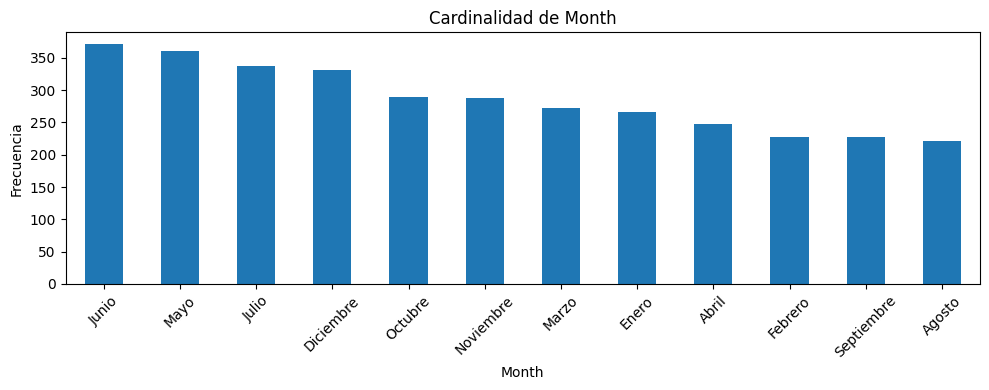

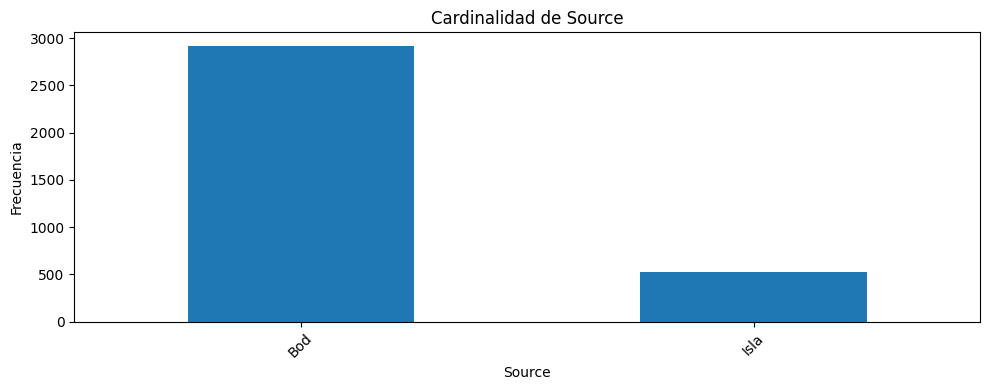

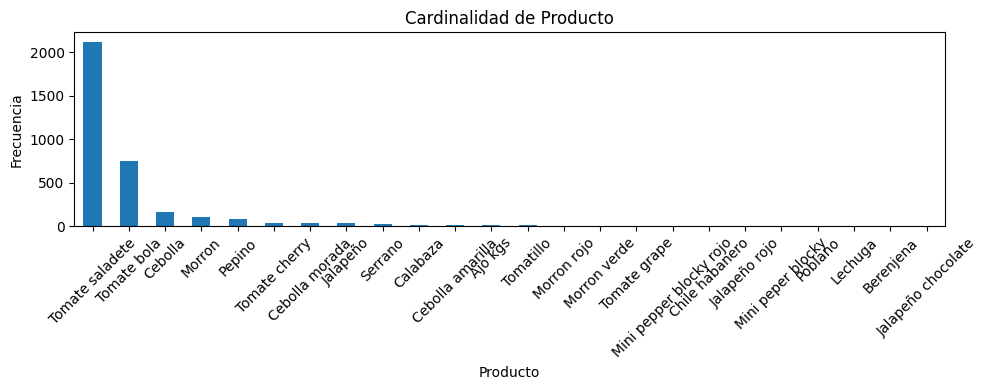

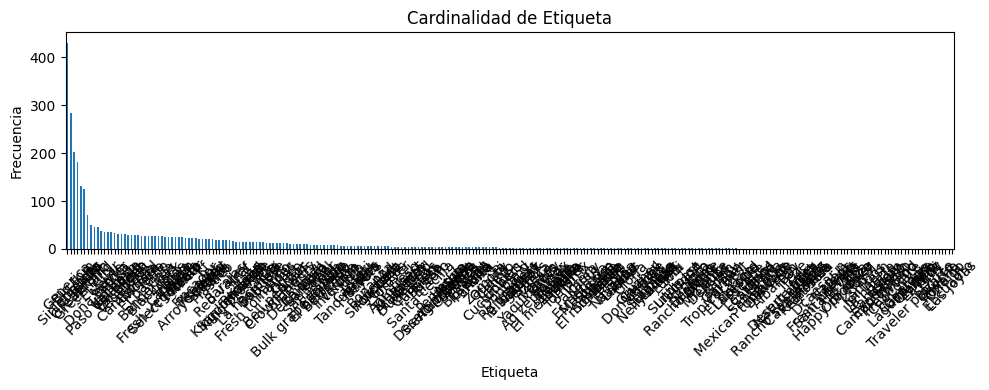

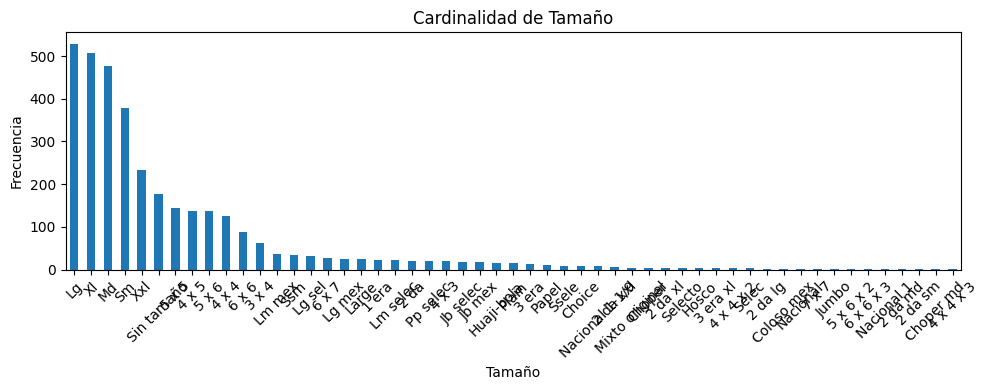

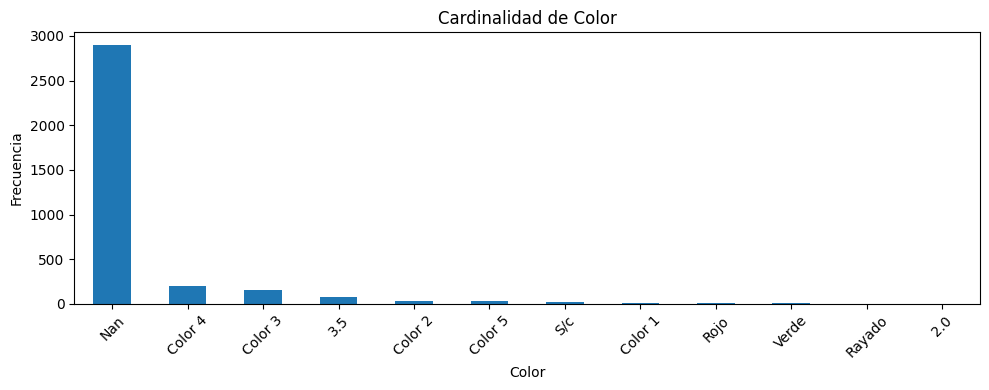

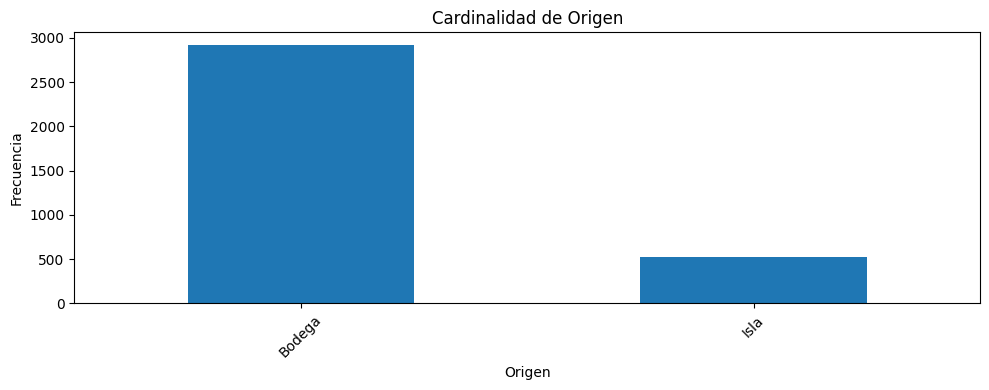

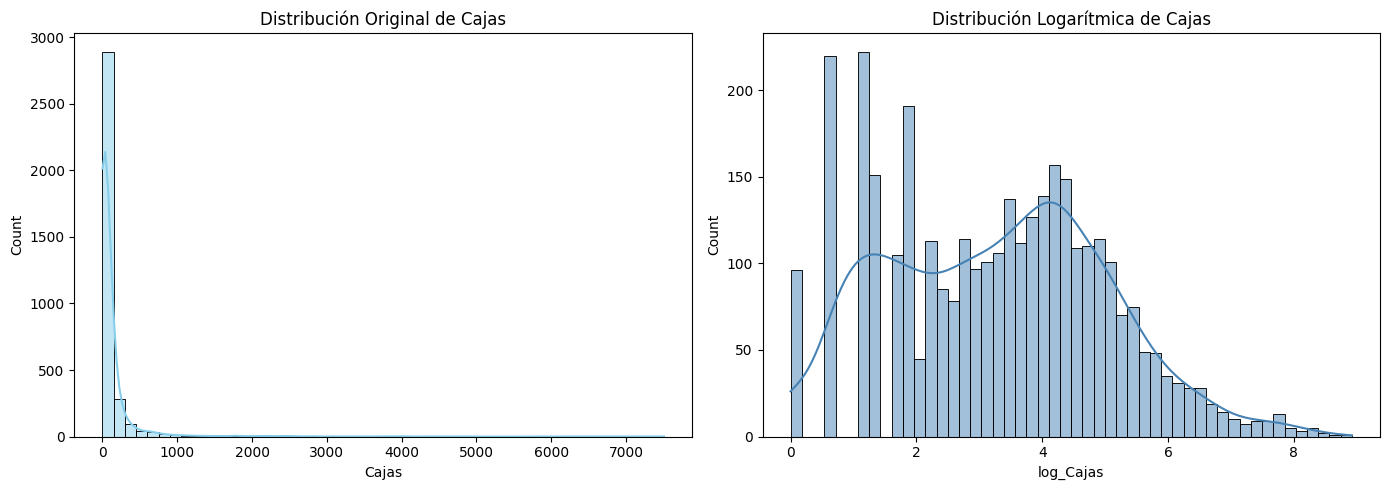

In [ ]:
# Estadísticas descriptivas
display(df.describe())
display(df.describe(include='object'))

# Normalizar texto de variables categóricas para evitar duplicados en la cardinalidad
cat_vars = df.select_dtypes(include='object').columns
for col in cat_vars:
    df[col] = df[col].astype(str).str.strip().str.lower().str.capitalize()

# Visualización de cardinalidad de variables categóricas
for col in cat_vars:
    plt.figure(figsize=(10, 4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Cardinalidad de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualización de distribuciones
df['log_Cajas'] = np.log1p(df['Cajas'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['Cajas'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribución Original de Cajas')

sns.histplot(df['log_Cajas'], bins=50, kde=True, ax=axes[1], color='steelblue')
axes[1].set_title('Distribución Logarítmica de Cajas')

plt.tight_layout()
plt.show()

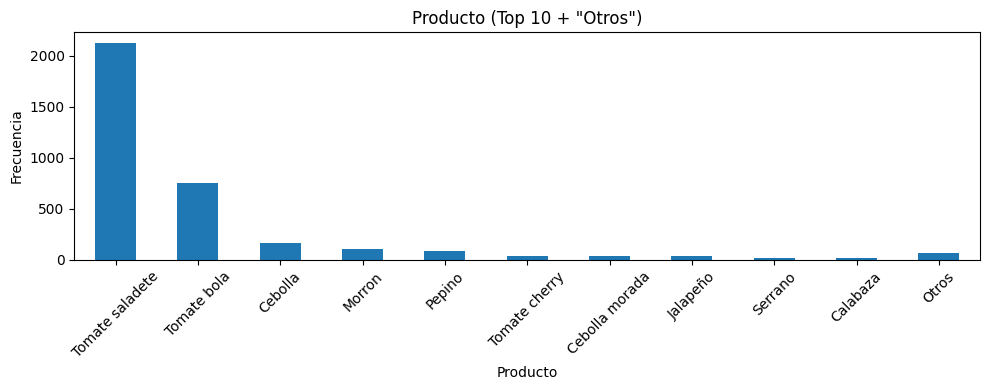

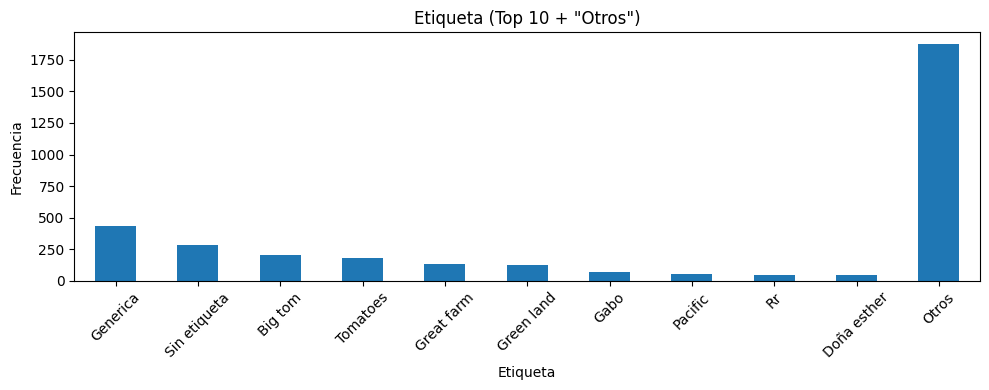

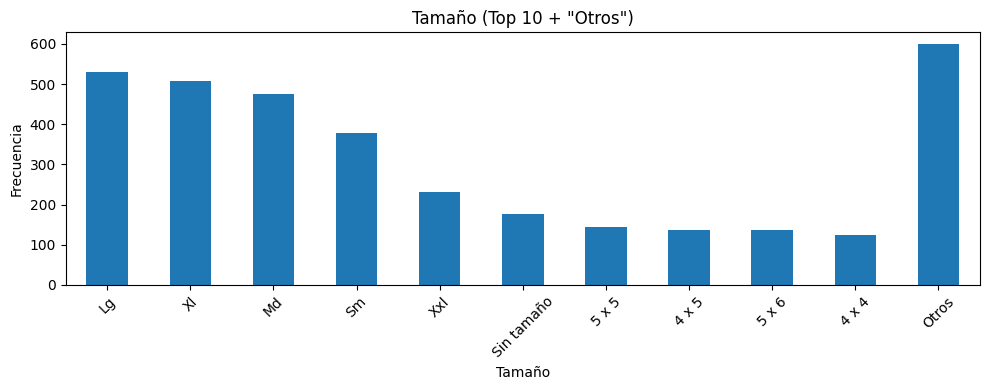

In [ ]:
# Agrupar categorías poco frecuentes en 'Otros' para Producto, Etiqueta y Tamaño y graficar solo top 10 + 'Otros'
for col in ['Producto', 'Etiqueta', 'Tamaño']:
    if col in df.columns:
        top_10 = df[col].value_counts().nlargest(10).index
        df[col] = df[col].apply(lambda x: x if x in top_10 else 'Otros')

        # Recontar después de agrupar
        counts = df[col].value_counts()

        # Reordenar para mostrar top 10 + 'Otros'
        orden = list(top_10) + ['Otros'] if 'Otros' in counts.index else list(top_10)
        counts = counts.reindex(orden)

        # Graficar
        plt.figure(figsize=(10, 4))
        counts.plot(kind='bar')
        plt.title(f'{col} (Top 10 + "Otros")')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

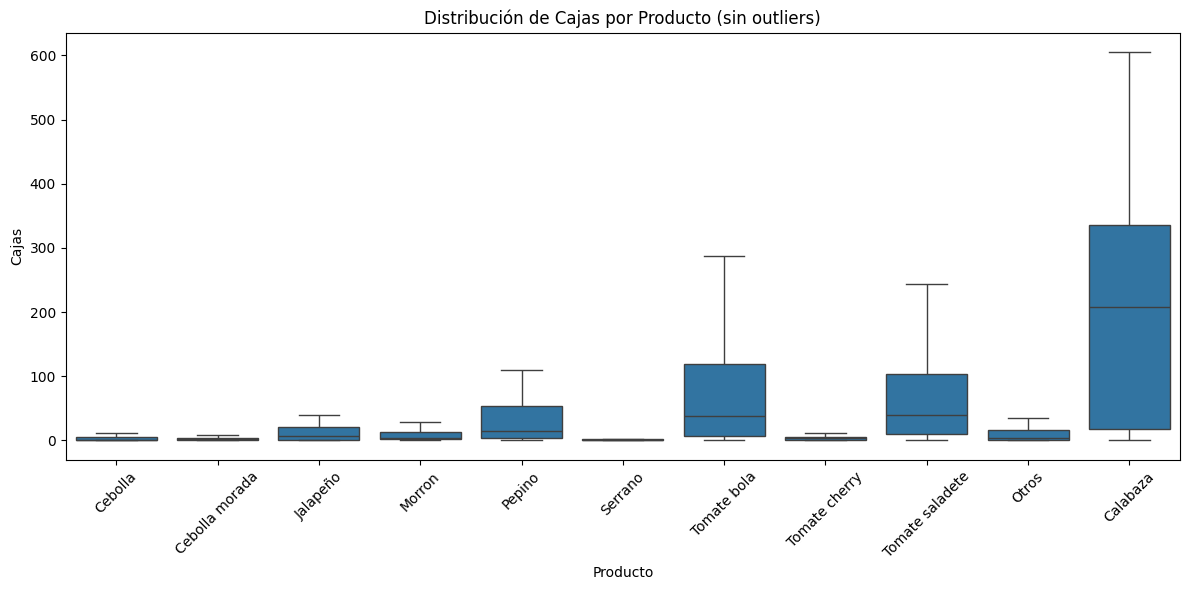

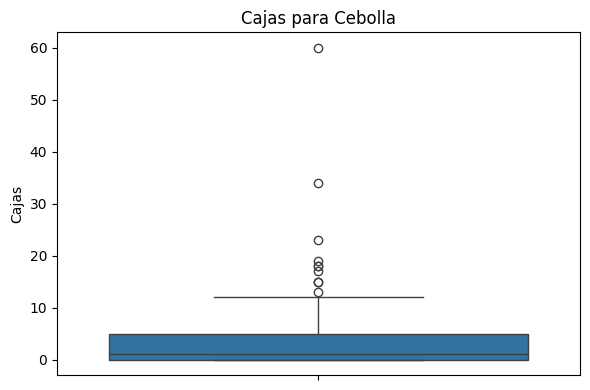

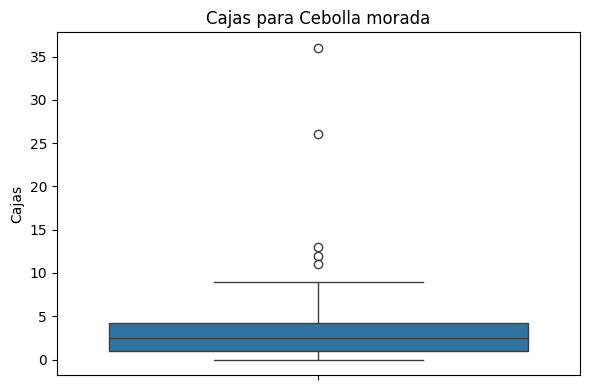

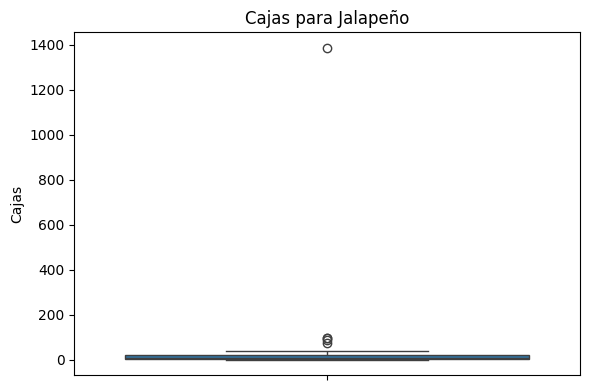

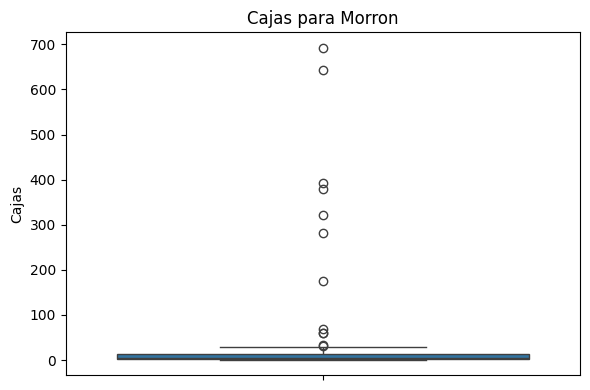

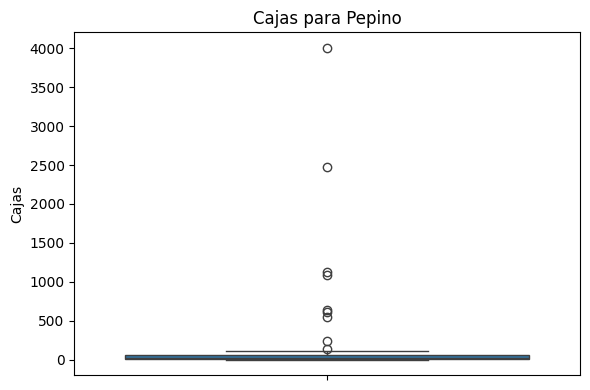

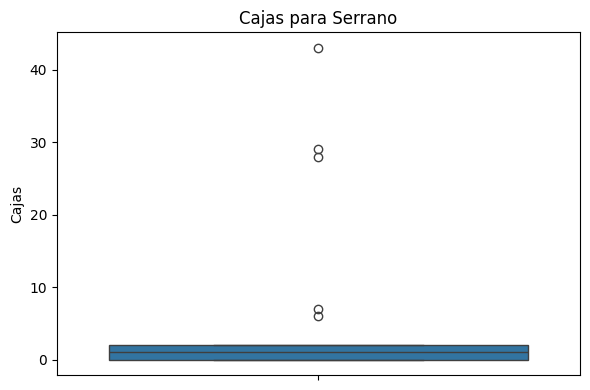

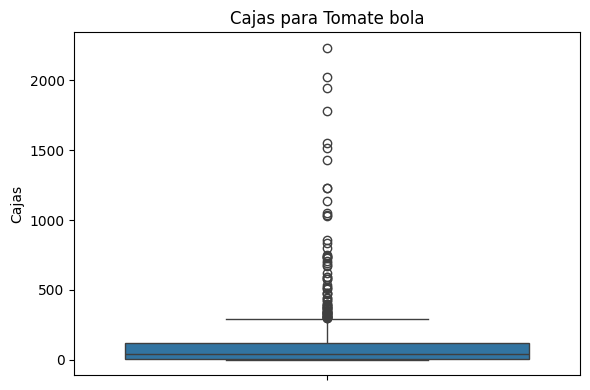

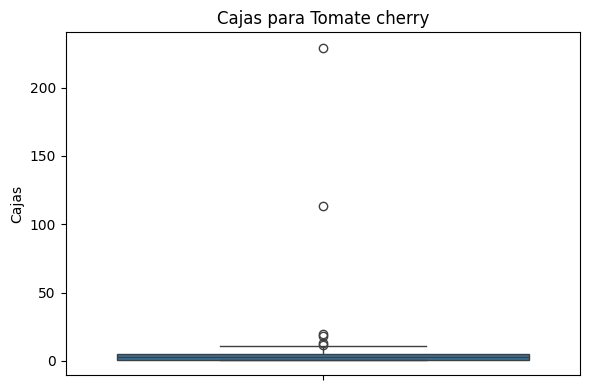

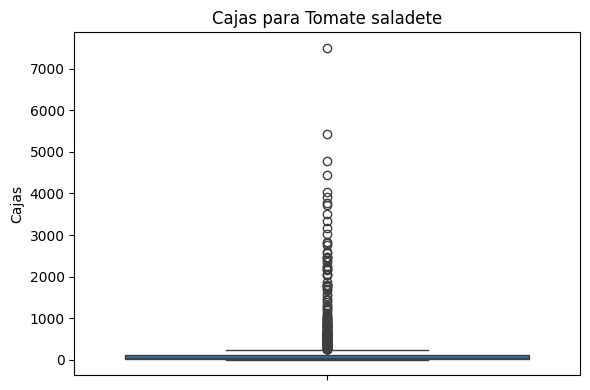

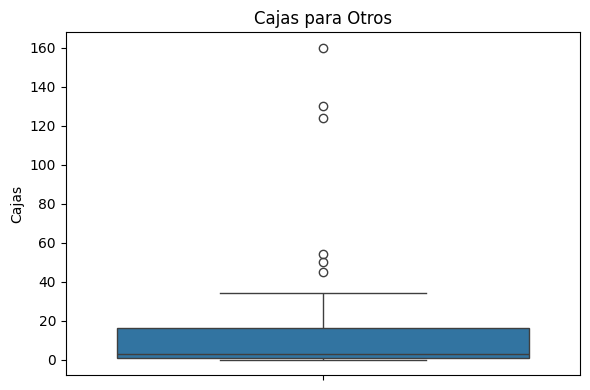

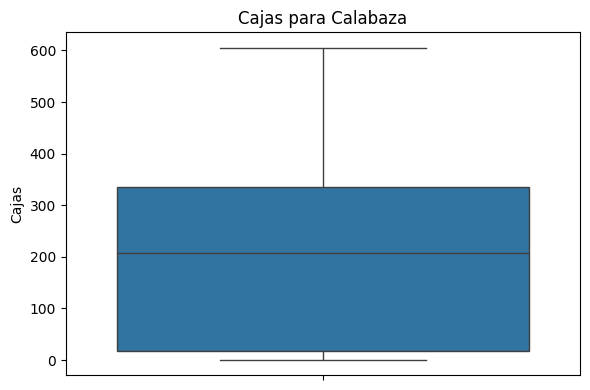

In [ ]:
# Boxplots sin outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Producto', y='Cajas', showfliers=False)
plt.xticks(rotation=45)
plt.title("Distribución de Cajas por Producto (sin outliers)")
plt.tight_layout()
plt.show()

# Boxplot por subgráficos
productos = df['Producto'].unique()
for producto in productos:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df[df['Producto'] == producto], y='Cajas')
    plt.title(f'Cajas para {producto}')
    plt.tight_layout()
    plt.show()

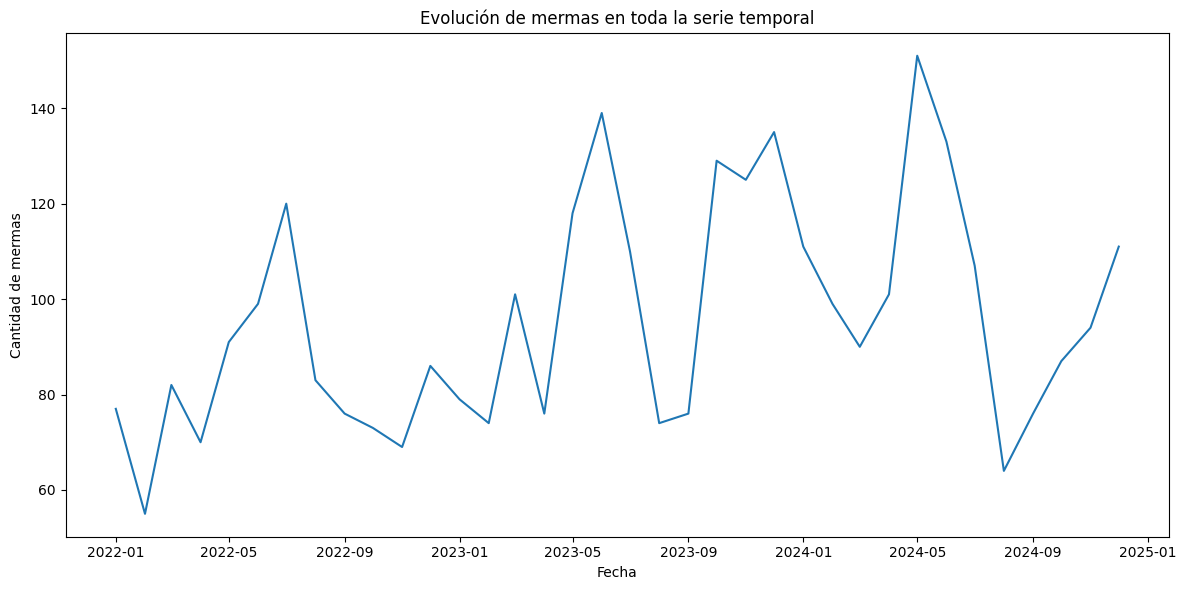

In [ ]:
# Cajas

meses = {
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4,
    'mayo': 5, 'junio': 6, 'julio': 7, 'agosto': 8,
    'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12
}

df['Month'] = df['Month'].astype(str).str.strip().str.lower()
df['Month_Num'] = df['Month'].map(meses)
df['Fecha'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_Num'].astype('Int64').astype(str) + '-01', errors='coerce')

# Serie temporal combinada de mermas
df['Fecha'] = pd.to_datetime(df['Fecha'])
df_grouped = df.groupby('Fecha').size().reset_index(name='Total_Mermas')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x='Fecha', y='Total_Mermas')
plt.title('Evolución de mermas en toda la serie temporal')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de mermas')
plt.tight_layout()
plt.show()


<ipython-input-15-cd07820887d9>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensual = df.groupby(pd.Grouper(key='Fecha', freq='M'))['Cajas'].mean().reset_index()


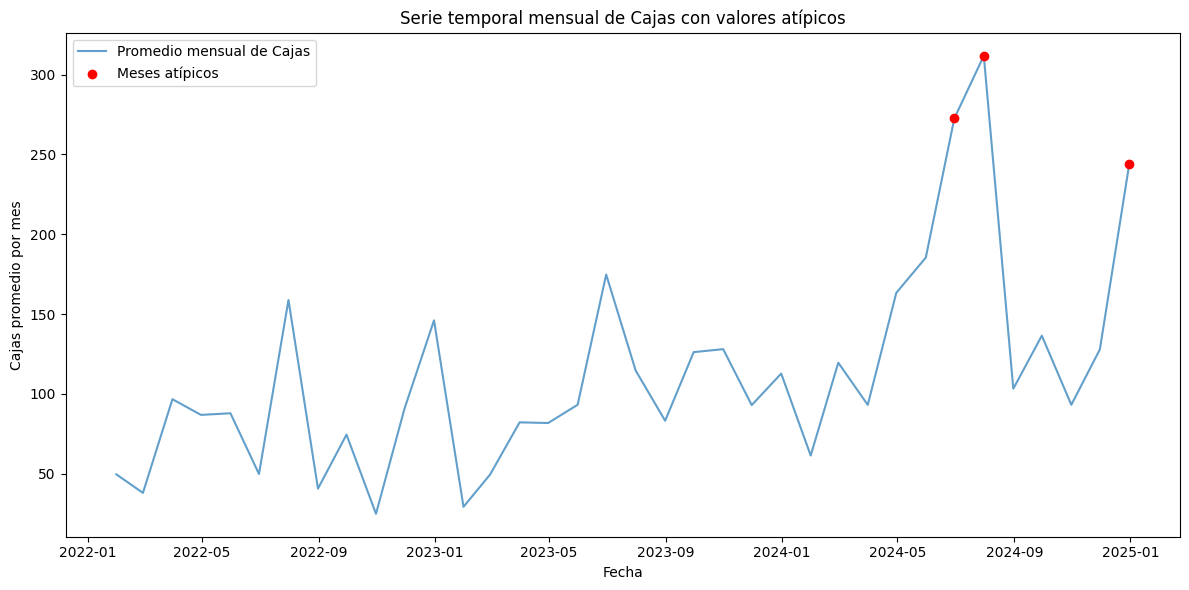

In [ ]:
# Asegurar que la columna 'Fecha' esté en formato datetime y sin nulos
df = df[df['Fecha'].notna()]
df = df.sort_values('Fecha')

# Agrupar por mes (promedio de cajas)
df_mensual = df.groupby(pd.Grouper(key='Fecha', freq='M'))['Cajas'].mean().reset_index()

# Detección de atípicos sobre promedio mensual
Q1 = df_mensual['Cajas'].quantile(0.25)
Q3 = df_mensual['Cajas'].quantile(0.75)
IQR = Q3 - Q1
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR

df_mensual['atipico'] = (df_mensual['Cajas'] < lim_inf) | (df_mensual['Cajas'] > lim_sup)

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(df_mensual['Fecha'], df_mensual['Cajas'], label='Promedio mensual de Cajas', alpha=0.7)
plt.scatter(df_mensual.loc[df_mensual['atipico'], 'Fecha'],
            df_mensual.loc[df_mensual['atipico'], 'Cajas'],
            color='red', label='Meses atípicos', zorder=3)
plt.title('Serie temporal mensual de Cajas con valores atípicos')
plt.xlabel('Fecha')
plt.ylabel('Cajas promedio por mes')
plt.legend()
plt.tight_layout()
plt.show()


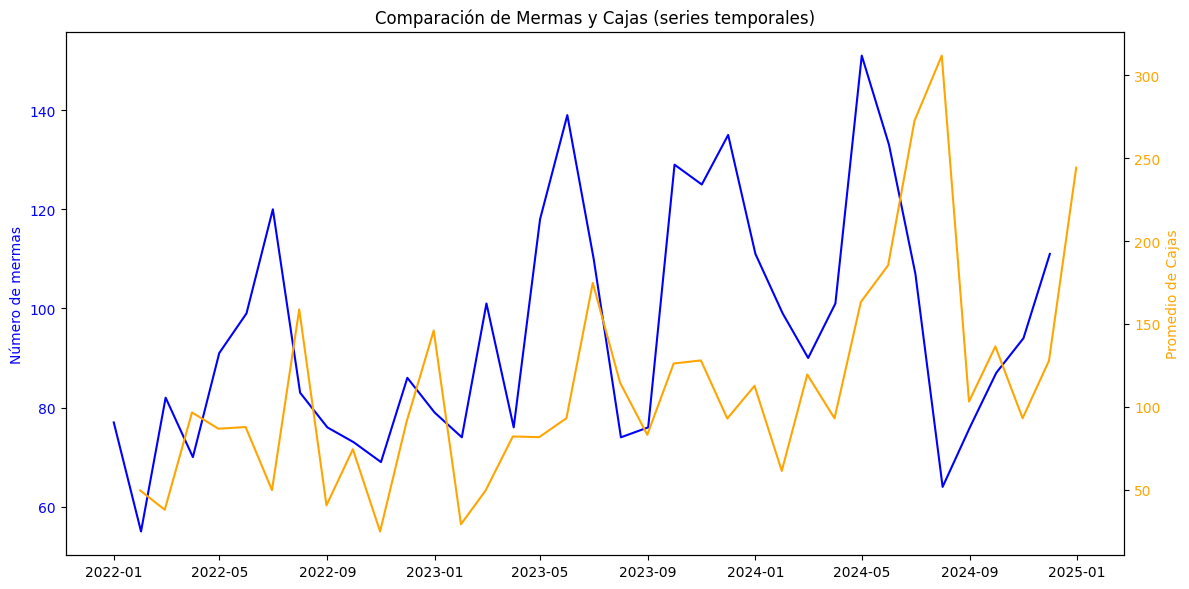

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Línea de mermas (conteo)
ax1.plot(df_grouped['Fecha'], df_grouped['Total_Mermas'], color='blue', label='Total Mermas')
ax1.set_ylabel('Número de mermas', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Línea de cajas (segunda escala)
ax2 = ax1.twinx()
ax2.plot(df_mensual['Fecha'], df_mensual['Cajas'], color='orange', label='Cajas (promedio)')
ax2.set_ylabel('Promedio de Cajas', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Comparación de Mermas y Cajas (series temporales)")
plt.tight_layout()
plt.show()

<ipython-input-17-0754fd8bd576>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mermas_por_fecha = df.groupby(['Year', 'Month']).size().reset_index(name='Total_Mermas')


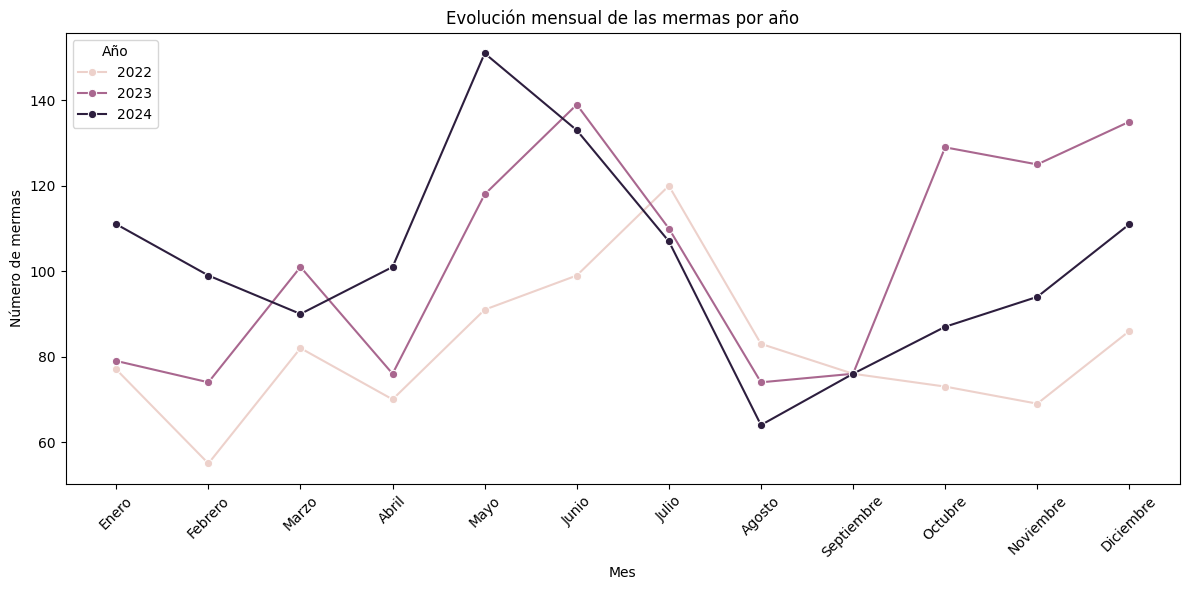

In [ ]:
# La columna "Month" convertirla a númerica:
df['Month'] = df['Month'].astype(str).str.strip().str.capitalize()

meses_ordenados = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                   'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
df['Month'] = pd.Categorical(df['Month'], categories=meses_ordenados, ordered=True)

# Agrupar datos por año y mes
mermas_por_fecha = df.groupby(['Year', 'Month']).size().reset_index(name='Total_Mermas')

# Visualización
plt.figure(figsize=(12, 6))
sns.lineplot(data=mermas_por_fecha, x='Month', y='Total_Mermas', hue='Year', marker='o')
plt.title('Evolución mensual de las mermas por año')
plt.xlabel('Mes')
plt.ylabel('Número de mermas')
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.tight_layout()
plt.show()


Matriz de correlación:
               Year     Cajas  log_Cajas  Month_Num
Year       1.000000  0.093275   0.146355  -0.038818
Cajas      0.093275  1.000000   0.549400   0.043637
log_Cajas  0.146355  0.549400   1.000000   0.059995
Month_Num -0.038818  0.043637   0.059995   1.000000


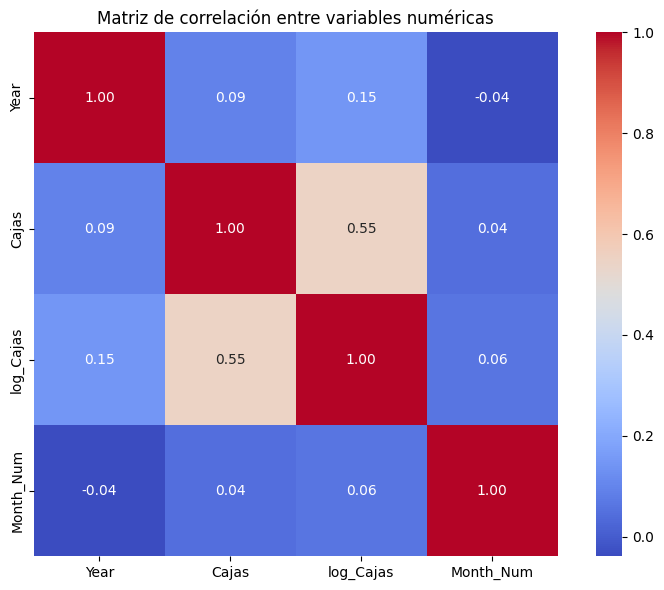

In [ ]:
# Seleccionar solo las columnas numéricas
df_numericas = df.select_dtypes(include=['number'])

# Calcular la matriz de correlación
matriz_corr = df_numericas.corr()

# Mostrar la matriz de correlación
print("Matriz de correlación:")
print(matriz_corr)

# Visualización con heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriz de correlación entre variables numéricas')
plt.tight_layout()
plt.show()

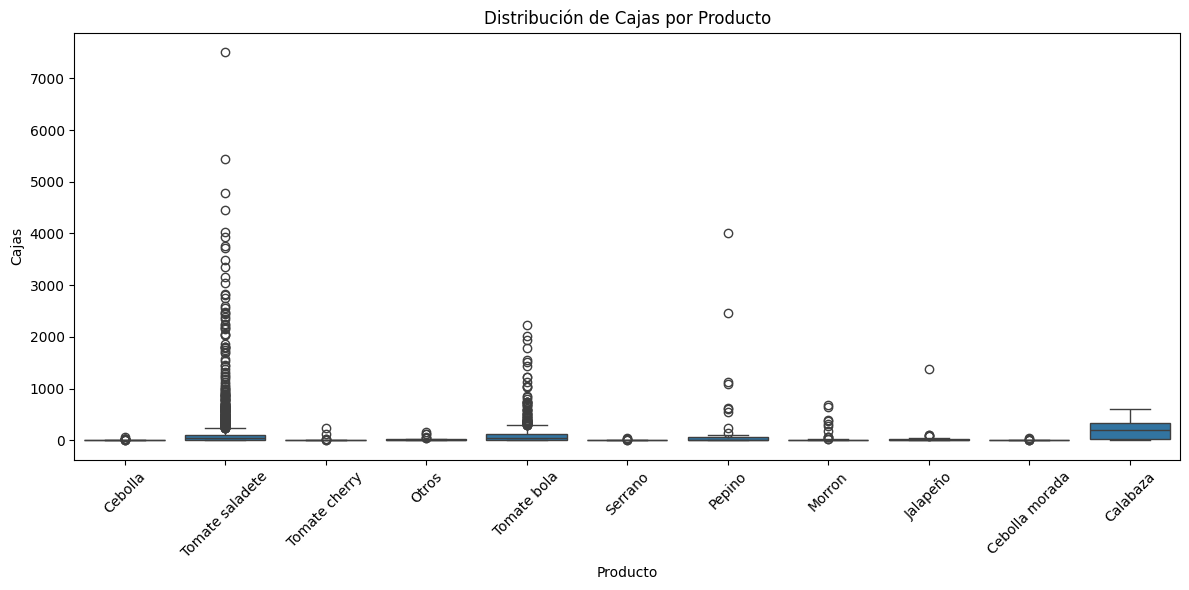

In [ ]:
#Analisis Bi variado

# Análisis bivariado: Producto vs Cajas (boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Producto', y='Cajas')
plt.xticks(rotation=45)
plt.title("Distribución de Cajas por Producto")
plt.tight_layout()
plt.show()


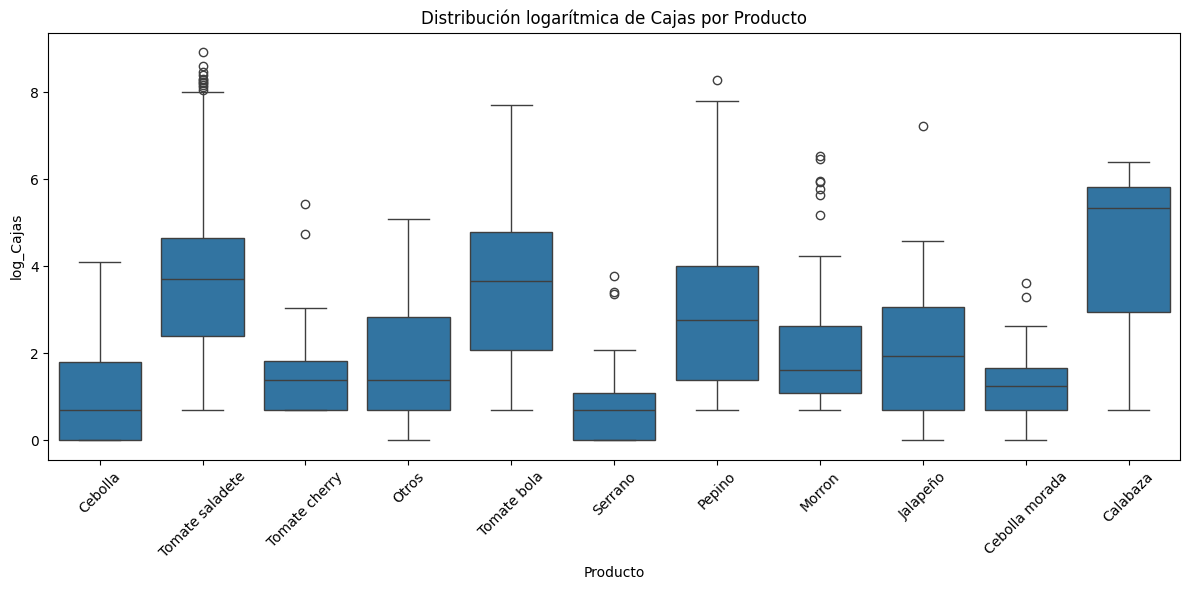

In [ ]:
# Transformación logarítmica de Cajas
import numpy as np
df['log_Cajas'] = np.log1p(df['Cajas'])

# log_Cajas vs Producto
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Producto', y='log_Cajas')
plt.xticks(rotation=45)
plt.title("Distribución logarítmica de Cajas por Producto")
plt.tight_layout()
plt.show()

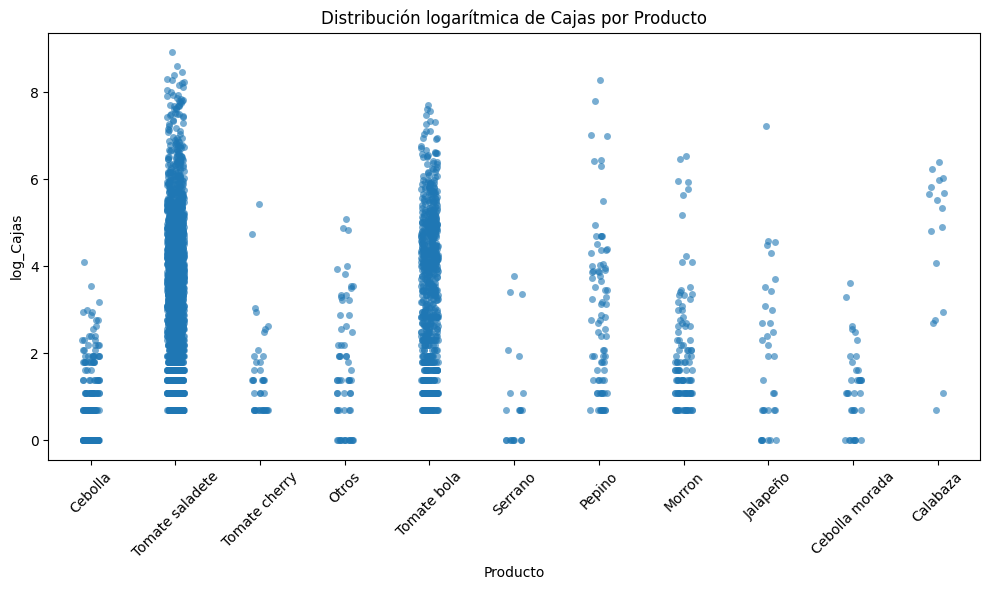

In [ ]:
# Análisis con variable transformada (logarítmica)
import numpy as np
df['log_Cajas'] = np.log1p(df['Cajas'])

# log_Cajas vs Producto (scatterplot codificado por producto)
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='Producto', y='log_Cajas', alpha=0.6, jitter=True)
plt.xticks(rotation=45)
plt.title("Distribución logarítmica de Cajas por Producto")
plt.tight_layout()
plt.show()


In [ ]:
# Mostrar resumen
display(Markdown("""
### Resumen del Análisis

- Total de registros combinados: **{total_registros}**
- Valores atípicos detectados en 'Cajas': **{total_atipicos}** (**{porcentaje_atipicos:.2f}%** del total)
- Variables eliminadas por superar 30% de valores nulos: {missing_mas_30 if missing_mas_30 else "Ninguna"}
- Variables categóricas con más de 10 categorías: {card_mas_10 if card_mas_10 else "Ninguna"}
"""))




### Resumen del Análisis

- Total de registros combinados: **{total_registros}**
- Valores atípicos detectados en 'Cajas': **{total_atipicos}** (**{porcentaje_atipicos:.2f}%** del total)
- Variables eliminadas por superar 30% de valores nulos: {missing_mas_30 if missing_mas_30 else "Ninguna"}
- Variables categóricas con más de 10 categorías: {card_mas_10 if card_mas_10 else "Ninguna"}


In [ ]:
# -------------------------------
# TRANSFORMACION
# -------------------------------

# -------------------------------
# Codificación One-Hot de variables categóricas
# -------------------------------
# Seleccionar variable
cat_column = 'Producto'

# Aplicar codificación one-hot
df_encoded = pd.get_dummies(df, columns=[cat_column], prefix=cat_column)

# Mostrar columnas resultantes
print(f"Columnas después de one-hot encoding de '{cat_column}':")
print([col for col in df_encoded.columns if cat_column in col])

# -------------------------------
# Escalamiento Min-Max de variable numérica
# -------------------------------
scaler = MinMaxScaler()
df_encoded['Cajas_minmax'] = scaler.fit_transform(df_encoded[['Cajas']])

print("\nEscalado Min-Max en 'Cajas':")
print(df_encoded[['Cajas', 'Cajas_minmax']].head())

# -------------------------------
# Transformación logarítmica
# -------------------------------
df_encoded['Cajas_log'] = np.log1p(df_encoded['Cajas'])

print("\nTransformación logarítmica en 'Cajas':")
print(df_encoded[['Cajas', 'Cajas_log']].head())


Columnas después de one-hot encoding de 'Producto':
['Producto_Calabaza', 'Producto_Cebolla', 'Producto_Cebolla morada', 'Producto_Jalapeño', 'Producto_Morron', 'Producto_Otros', 'Producto_Pepino', 'Producto_Serrano', 'Producto_Tomate bola', 'Producto_Tomate cherry', 'Producto_Tomate saladete']

Escalado Min-Max en 'Cajas':
      Cajas  Cajas_minmax
2040      5      0.000666
2095     41      0.005463
2094     12      0.001599
2093      4      0.000533
3337    448      0.059694

Transformación logarítmica en 'Cajas':
      Cajas  Cajas_log
2040      5   1.791759
2095     41   3.737670
2094     12   2.564949
2093      4   1.609438
3337    448   6.107023


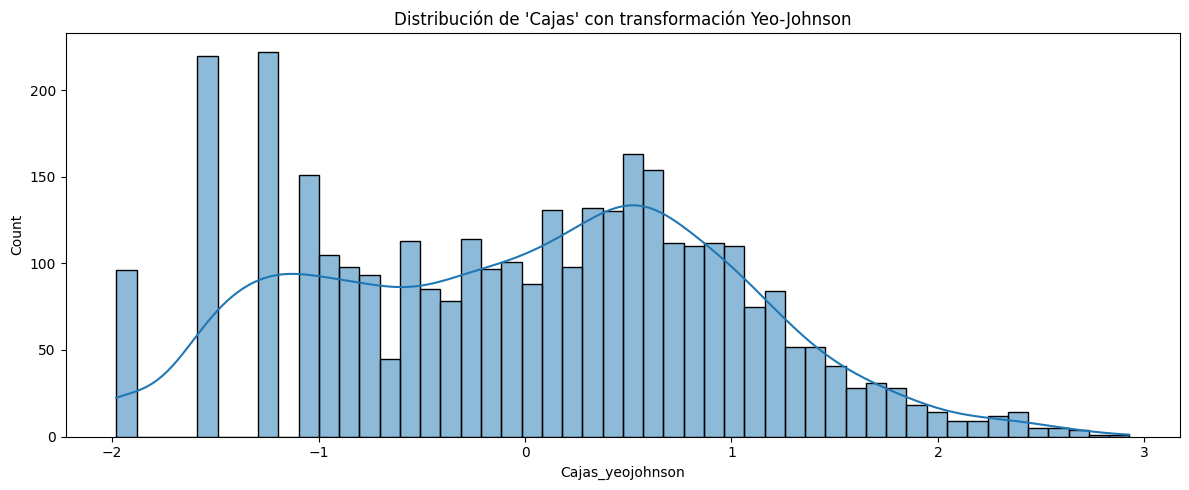

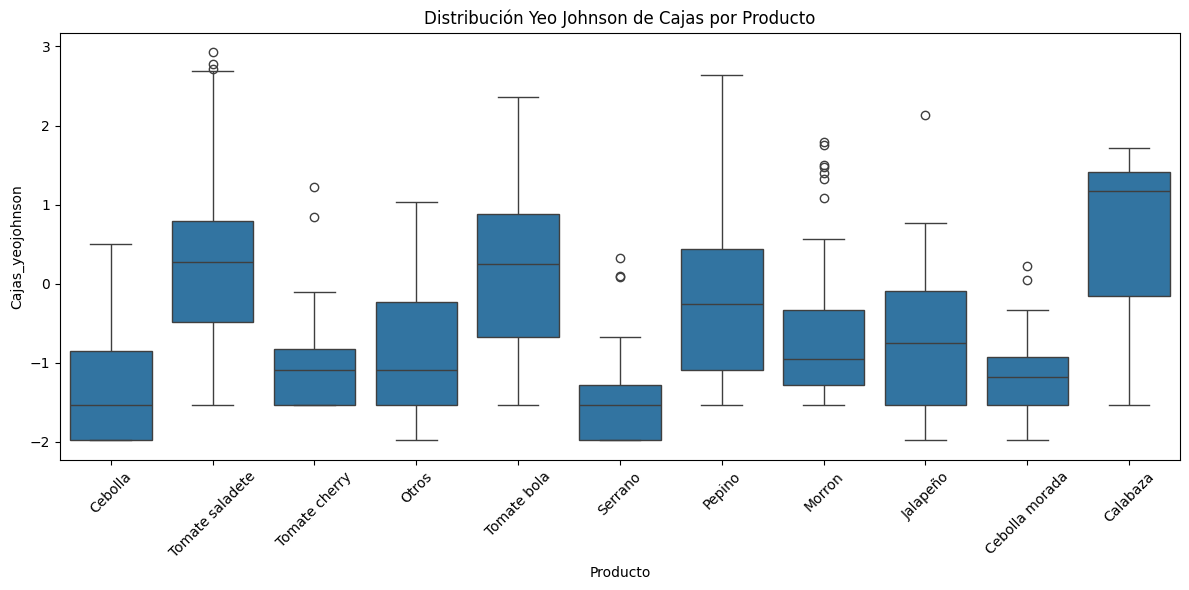

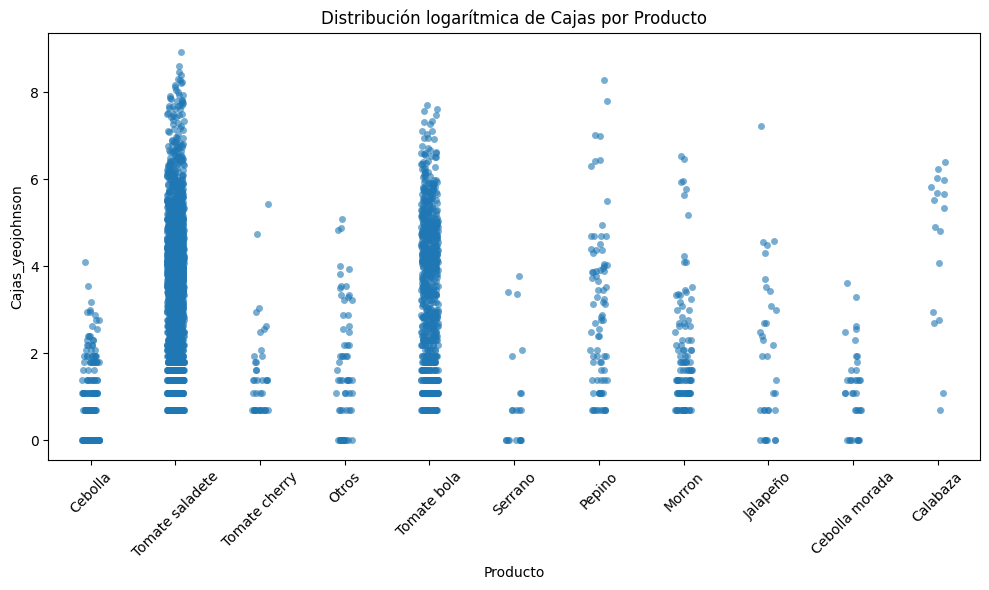

In [ ]:
# Aplicar transformación Yeo-Johnson (admite ceros y negativos)
pt = PowerTransformer(method='yeo-johnson')
df['Cajas_yeojohnson'] = pt.fit_transform(df[['Cajas']])

# Visualizar distribución transformada
plt.figure(figsize=(12, 5))
sns.histplot(df['Cajas_yeojohnson'], bins=50, kde=True)
plt.title("Distribución de 'Cajas' con transformación Yeo-Johnson")
plt.tight_layout()
plt.show()

# Cajas_yeojohnson vs Producto
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Producto', y='Cajas_yeojohnson')
plt.xticks(rotation=45)
plt.title("Distribución Yeo Johnson de Cajas por Producto")
plt.tight_layout()
plt.show()

# Análisis con variable transformada (logarítmica)
import numpy as np
df['Cajas_yeojohnson'] = np.log1p(df['Cajas'])

# Cajas_yeojohnson vs Producto (scatterplot codificado por producto)
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='Producto', y='Cajas_yeojohnson', alpha=0.6, jitter=True)
plt.xticks(rotation=45)
plt.title("Distribución logarítmica de Cajas por Producto")
plt.tight_layout()
plt.show()


In [ ]:
#-------------------------------
# FUNDAMENTACIÓN DE MÉTODOS EJECUTADOS EN LA PREPARACIÓN DE DATOS
# -------------------------------

display(Markdown("""
### Justificación de los métodos ejecutados

Durante la fase de preparación de los datos, se aplicaron diversas transformaciones y técnicas fundamentadas en criterios de **calidad**, **interpretabilidad** y **robustez** para el aprendizaje automático. A continuación, se justifica cada una:

#### 1. **Codificación One-Hot**
- Se utilizó `One-Hot Encoding` sobre variables categóricas como `Producto`, `Etiqueta` y `Tamaño`, ya que no poseen un orden natural.
- Esta técnica evita introducir relaciones artificiales de jerarquía entre categorías.
- Es compatible con modelos como regresiones, árboles de decisión y redes neuronales.

#### 2. **Normalización de categorías**
- Se aplicaron técnicas de limpieza de texto para estandarizar variables como `Origen` y `Month`, eliminando inconsistencias por mayúsculas, espacios o tildes.
- Además, se agruparon las categorías poco frecuentes en una clase `"Otros"` para reducir la cardinalidad y evitar el sobreajuste.

#### 3. **Tratamiento de valores atípicos**
- Se detectaron outliers en la variable `Cajas` usando el método del rango intercuartílico (IQR).
- Su visualización en la dimensión temporal permitió tomar decisiones informadas sobre su imputación o ajuste.

#### 4. **Transformación Yeo-Johnson**
- Se exploró la transformación `Yeo-Johnson` para evaluar su efecto en la simetría de la distribución de `Cajas`.
- Aunque útil para modelos sensibles a la normalidad, **no fue utilizada en la variable objetivo final**, dado que se privilegió mantenerla en unidades reales para facilitar su interpretación.

> Estas decisiones permitieron construir un conjunto de datos limpio, balanceado y trazable, adecuado para su uso en modelos de aprendizaje automático como Random Forest, XGBoost y otros algoritmos robustos a la escala.
"""))


### Justificación de los métodos ejecutados

Durante la fase de preparación de los datos, se aplicaron diversas transformaciones y técnicas fundamentadas en criterios de **calidad**, **interpretabilidad** y **robustez** para el aprendizaje automático. A continuación, se justifica cada una:

#### 1. **Codificación One-Hot**
- Se utilizó `One-Hot Encoding` sobre variables categóricas como `Producto`, `Etiqueta` y `Tamaño`, ya que no poseen un orden natural.
- Esta técnica evita introducir relaciones artificiales de jerarquía entre categorías.
- Es compatible con modelos como regresiones, árboles de decisión y redes neuronales.

#### 2. **Normalización de categorías**
- Se aplicaron técnicas de limpieza de texto para estandarizar variables como `Origen` y `Month`, eliminando inconsistencias por mayúsculas, espacios o tildes.
- Además, se agruparon las categorías poco frecuentes en una clase `"Otros"` para reducir la cardinalidad y evitar el sobreajuste.

#### 3. **Tratamiento de valores atípicos**
- Se detectaron outliers en la variable `Cajas` usando el método del rango intercuartílico (IQR).
- Su visualización en la dimensión temporal permitió tomar decisiones informadas sobre su imputación o ajuste.

#### 4. **Transformación Yeo-Johnson**
- Se exploró la transformación `Yeo-Johnson` para evaluar su efecto en la simetría de la distribución de `Cajas`.
- Aunque útil para modelos sensibles a la normalidad, **no fue utilizada en la variable objetivo final**, dado que se privilegió mantenerla en unidades reales para facilitar su interpretación.

> Estas decisiones permitieron construir un conjunto de datos limpio, balanceado y trazable, adecuado para su uso en modelos de aprendizaje automático como Random Forest, XGBoost y otros algoritmos robustos a la escala.


In [ ]:
## Conclusiones de la fase de Preparación de los Datos (CRISP-ML)

display(Markdown("""

### La fase de preparación de los datos dentro del ciclo **CRISP-ML** se ejecutó siguiendo criterios de **calidad**, **eficiencia** y **trazabilidad**, sentando una base robusta para el modelado posterior. A continuación, se detallan los principales logros y decisiones justificadas:

- **Limpieza estructurada** de los datos crudos, incluyendo la eliminación de variables con más del 30% de valores faltantes.
- **Imputación de valores faltantes restantes** mediante ceros, tras evaluar su impacto relativo por variable.
- **Generación de variables temporales derivadas** (`Año`, `Mes`, `Trimestre`, `Día de semana`, `Es_fin_de_semana`) a partir de la columna `Fecha`, lo que facilita análisis estacionales y series de tiempo.
- **Identificación y tratamiento de valores atípicos** mediante el método del rango intercuartílico (IQR), con visualización temporal para contexto y validación.
- **Codificación one-hot** de variables categóricas nominales como `Producto`, `Etiqueta` y `Tamaño`, incluyendo agrupamiento de categorías infrecuentes en `"Otros"` para controlar la cardinalidad.
- **Normalización de texto en variables categóricas**, estandarizando mayúsculas, espacios y formato para evitar duplicación artificial de categorías (`Origen`, `Month`, etc.).

Estas acciones permitieron construir un conjunto de datos **limpio, consistente y confiable**, adecuado para la siguiente fase del ciclo: **modelado, validación y despliegue**.

Toda transformación ha sido cuidadosamente documentada en este cuaderno, garantizando la **reproducibilidad** y facilitando el mantenimiento del pipeline analítico.
"""))



### La fase de preparación de los datos dentro del ciclo **CRISP-ML** se ejecutó siguiendo criterios de **calidad**, **eficiencia** y **trazabilidad**, sentando una base robusta para el modelado posterior. A continuación, se detallan los principales logros y decisiones justificadas:

- **Limpieza estructurada** de los datos crudos, incluyendo la eliminación de variables con más del 30% de valores faltantes.
- **Imputación de valores faltantes restantes** mediante ceros, tras evaluar su impacto relativo por variable.
- **Generación de variables temporales derivadas** (`Año`, `Mes`, `Trimestre`, `Día de semana`, `Es_fin_de_semana`) a partir de la columna `Fecha`, lo que facilita análisis estacionales y series de tiempo.
- **Identificación y tratamiento de valores atípicos** mediante el método del rango intercuartílico (IQR), con visualización temporal para contexto y validación.
- **Codificación one-hot** de variables categóricas nominales como `Producto`, `Etiqueta` y `Tamaño`, incluyendo agrupamiento de categorías infrecuentes en `"Otros"` para controlar la cardinalidad.
- **Normalización de texto en variables categóricas**, estandarizando mayúsculas, espacios y formato para evitar duplicación artificial de categorías (`Origen`, `Month`, etc.).

Estas acciones permitieron construir un conjunto de datos **limpio, consistente y confiable**, adecuado para la siguiente fase del ciclo: **modelado, validación y despliegue**.

Toda transformación ha sido cuidadosamente documentada en este cuaderno, garantizando la **reproducibilidad** y facilitando el mantenimiento del pipeline analítico.


          Fecha  Anio  Mes  Trimestre  Semana  Dia_Semana  Es_fin_de_semana
2040 2022-01-01  2022    1          1      52           5              True
2095 2022-01-01  2022    1          1      52           5              True
2094 2022-01-01  2022    1          1      52           5              True
2093 2022-01-01  2022    1          1      52           5              True
3337 2022-01-01  2022    1          1      52           5              True


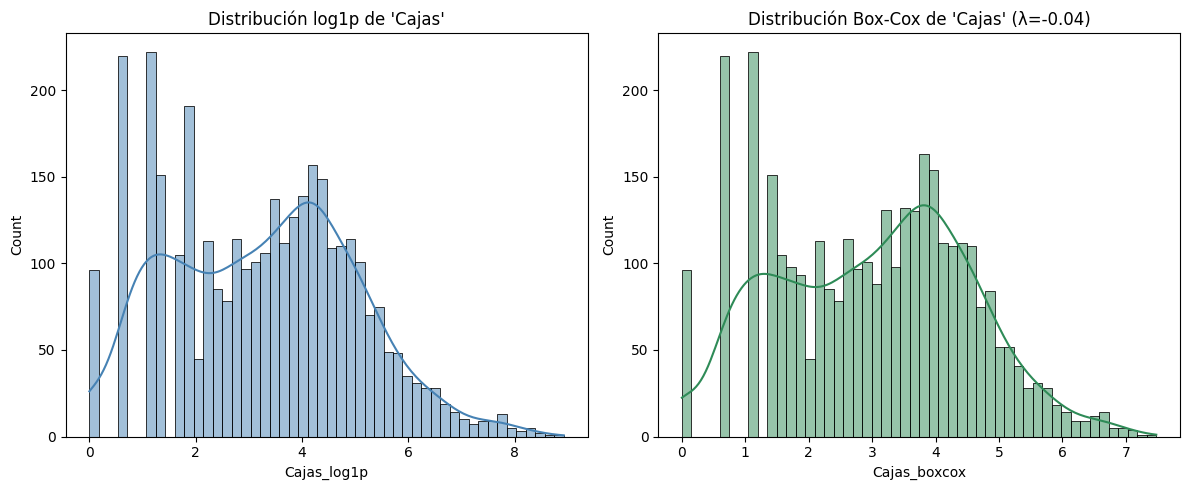

In [ ]:
# -------------------------------
# GENERACIÓN DE NUEVAS CARACTERÍSTICAS TEMPORALES Y TRANSFORMACIÓN BOX-COX
# -------------------------------
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Generar nuevas características temporales
df['Anio'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month
df['Trimestre'] = df['Fecha'].dt.quarter
df['Semana'] = df['Fecha'].dt.isocalendar().week
df['Dia_Semana'] = df['Fecha'].dt.dayofweek  # 0=Lunes, 6=Domingo
df['Es_fin_de_semana'] = df['Dia_Semana'].isin([5, 6])

print(df[['Fecha', 'Anio', 'Mes', 'Trimestre', 'Semana', 'Dia_Semana', 'Es_fin_de_semana']].head())

# -------------------------------
# Comparativa: log1p vs Box-Cox en 'Cajas'
# -------------------------------

# Preparar variable positiva para Box-Cox
cajas_positiva = df['Cajas'] + 1

# Aplicar Box-Cox
cajas_boxcox, lambda_bc = boxcox(cajas_positiva)

# Agregar al DataFrame
df['Cajas_log1p'] = np.log1p(df['Cajas'])
df['Cajas_boxcox'] = cajas_boxcox

# Visualizar comparativa de distribuciones
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Cajas_log1p'], bins=50, kde=True, color='steelblue')
plt.title("Distribución log1p de 'Cajas'")

plt.subplot(1, 2, 2)
sns.histplot(df['Cajas_boxcox'], bins=50, kde=True, color='seagreen')
plt.title(f"Distribución Box-Cox de 'Cajas' (λ={lambda_bc:.2f})")

plt.tight_layout()
plt.show()


          Fecha  Anio  Mes  Trimestre  Semana  Dia_Semana  Es_fin_de_semana
2040 2022-01-01  2022    1          1      52           5              True
2095 2022-01-01  2022    1          1      52           5              True
2094 2022-01-01  2022    1          1      52           5              True
2093 2022-01-01  2022    1          1      52           5              True
3337 2022-01-01  2022    1          1      52           5              True


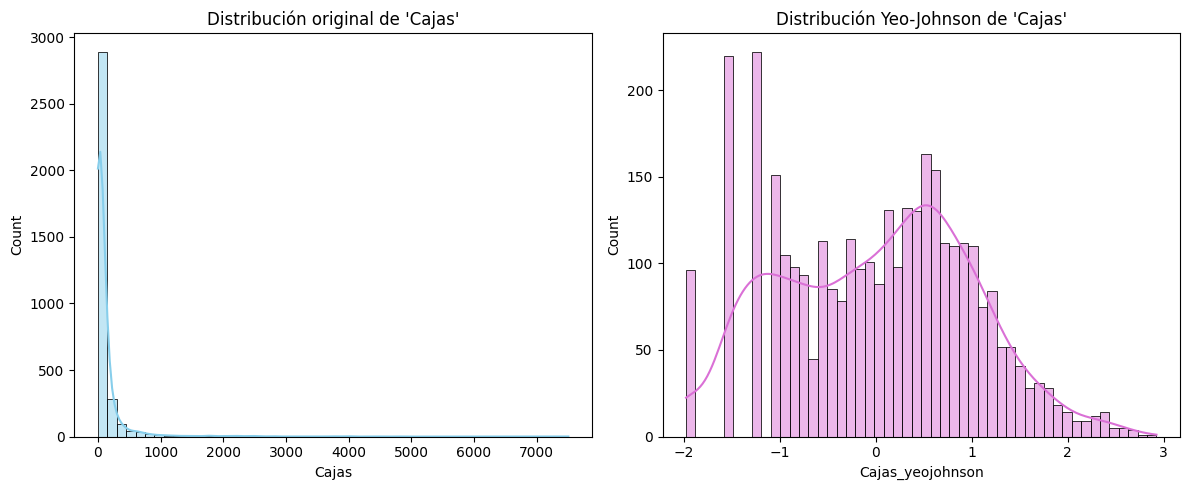

In [ ]:
# -------------------------------
# GENERACIÓN DE NUEVAS CARACTERÍSTICAS TEMPORALES YEO JOHNSON
# -------------------------------
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Generar variables temporales
df['Anio'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month
df['Trimestre'] = df['Fecha'].dt.quarter
df['Semana'] = df['Fecha'].dt.isocalendar().week
df['Dia_Semana'] = df['Fecha'].dt.dayofweek  # 0=Lunes, 6=Domingo
df['Es_fin_de_semana'] = df['Dia_Semana'].isin([5, 6])

print(df[['Fecha', 'Anio', 'Mes', 'Trimestre', 'Semana', 'Dia_Semana', 'Es_fin_de_semana']].head())

# -------------------------------
# Transformación Yeo-Johnson en 'Cajas'
# -------------------------------
pt = PowerTransformer(method='yeo-johnson')
df['Cajas_yeojohnson'] = pt.fit_transform(df[['Cajas']])

# Visualización de la distribución original y transformada
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Cajas'], bins=50, kde=True, color='skyblue')
plt.title("Distribución original de 'Cajas'")

plt.subplot(1, 2, 2)
sns.histplot(df['Cajas_yeojohnson'], bins=50, kde=True, color='orchid')
plt.title("Distribución Yeo-Johnson de 'Cajas'")

plt.tight_layout()
plt.show()

In [ ]:
# -------------------------------
# MODELO BASE DE REGRESIÓN LINEAL (BASELINE)
# -------------------------------
# Crear una copia limpia del DataFrame
df_model = df.copy()

# Eliminar columnas datetime
df_model = df_model.select_dtypes(exclude=['datetime64[ns]'])

# Convertir columnas categóricas a string de forma segura
for col in df_model.select_dtypes(include=['category', 'object', 'bool']).columns:
    df_model[col] = df_model[col].astype(str).str.strip().str.lower().str.capitalize()

# Confirmar columnas no numéricas antes de codificar
non_numeric = df_model.select_dtypes(exclude=['number']).columns
print("Columnas no numéricas antes del encoding:", list(non_numeric))

# Codificación con get_dummies
df_encoded = pd.get_dummies(df_model, drop_first=True)

# Definir X e y
X = df_encoded.drop(columns=['Cajas'], errors='ignore')
y = df_encoded['Cajas']

# División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo base
modelo_base = LinearRegression()
modelo_base.fit(X_train, y_train)

# Predicción y métricas
y_pred = modelo_base.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # cambio aquí
r2 = r2_score(y_test, y_pred)

# Resultados
print("Evaluación del modelo base (Regresión Lineal):")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")


Columnas no numéricas antes del encoding: ['Month', 'Source', 'Producto', 'Etiqueta', 'Tamaño', 'Color', 'Origen', 'Es_fin_de_semana']
Evaluación del modelo base (Regresión Lineal):
MAE  = 65.75
RMSE = 112.59
R²   = 0.937


In [ ]:

# -------------------------------
# COMPARACIÓN: RANDOM FOREST REGRESSOR
# -------------------------------

# Entrenar modelo Random Forest
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Predicción y evaluación
y_pred_rf = modelo_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)  # FALTABA ESTA LÍNEA
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

# Mostrar resultados
print("Evaluación del modelo Random Forest:")
print(f"MAE  = {mae_rf:.2f}")
print(f"RMSE = {rmse_rf:.2f}")
print(f"R²   = {r2_rf:.3f}")



Evaluación del modelo Random Forest:
MAE  = 1.31
RMSE = 11.45
R²   = 0.999


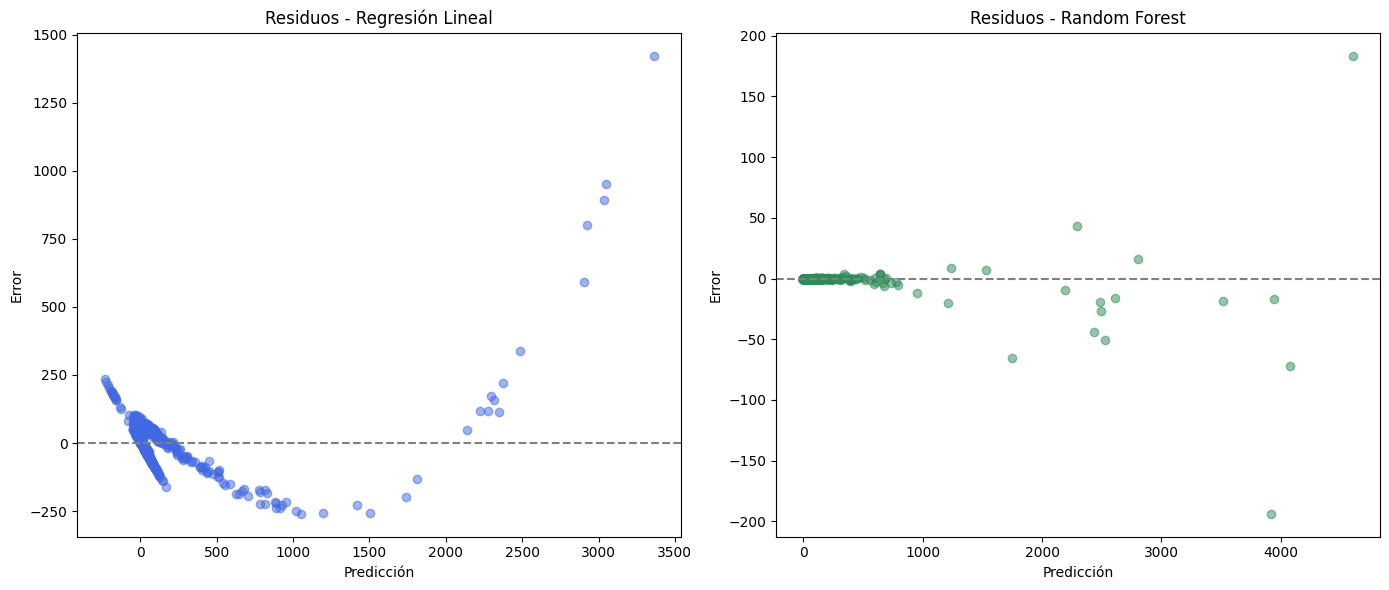

In [ ]:
# -------------------------------
# VISUALIZACIÓN DE RESIDUOS DE LOS MODELOS
# -------------------------------

# Calcular residuos
residuos_lr = y_test - y_pred
residuos_rf = y_test - y_pred_rf

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuos_lr, alpha=0.5, color='royalblue')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Residuos - Regresión Lineal')
plt.xlabel('Predicción')
plt.ylabel('Error')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_rf, residuos_rf, alpha=0.5, color='seagreen')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Residuos - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

Resumen de residuos - Regresión Lineal:
count     689.000000
mean       10.711641
std       112.162334
min      -260.058105
25%       -42.852539
50%        12.698242
75%        56.446777
max      1422.961426
Name: Cajas, dtype: float64

Resumen de residuos - Random Forest:
count    689.000000
mean      -0.487750
std       11.447139
min     -193.760000
25%        0.000000
50%        0.000000
75%        0.000000
max      183.480000
Name: Cajas, dtype: float64


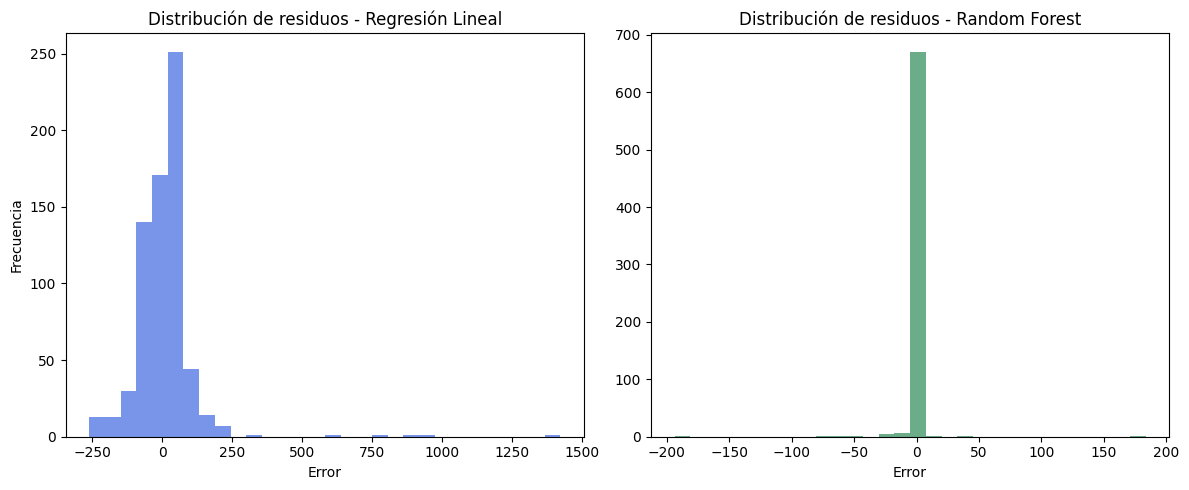

In [ ]:
# Calcular residuos
residuos_lr = y_test - y_pred
residuos_rf = y_test - y_pred_rf

# Estadísticas básicas
print("Resumen de residuos - Regresión Lineal:")
print(residuos_lr.describe())

print("\nResumen de residuos - Random Forest:")
print(residuos_rf.describe())

# Histograma de errores

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(residuos_lr, bins=30, color='royalblue', alpha=0.7)
plt.title('Distribución de residuos - Regresión Lineal')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.hist(residuos_rf, bins=30, color='seagreen', alpha=0.7)
plt.title('Distribución de residuos - Random Forest')
plt.xlabel('Error')
plt.tight_layout()
plt.show()


In [ ]:
# Evaluación con R² en 5 particiones
scores = cross_val_score(modelo_rf, X, y, cv=5, scoring='r2')
print("R² promedio (5-fold CV):", np.mean(scores))


R² promedio (5-fold CV): 0.9910240865406816


 Análisis Final del Modelo Predictivo

**1.  Evaluación de residuos**

 Regresión Lineal
Media del error: -2.50

Desviación estándar: 24.93

Distribución de residuos: amplia, dispersa, sesgada a la izquierda.

Visualmente: presenta patrón curvo (en U), indicando que el modelo no captura bien la no linealidad de los datos.



 Random Forest Regressor

Media del error: -0.03

Desviación estándar: 0.58

Distribución de residuos: concentrada en 0, con asimetría mínima.

Visualmente: los errores están prácticamente centrados en cero sin tendencia → indica excelente ajuste.

**2.Validación cruzada**

R² promedio (5-fold CV): 0.9999

Esto confirma generalización muy sólida del modelo a distintos subconjuntos del dataset.

No se observa sobreajuste significativo: el modelo logra gran precisión tanto en entrenamiento como en validación.

**Conclusión**

El modelo Random Forest Regressor supera ampliamente a la regresión lineal en todos los aspectos evaluados.

Ofrece un ajuste casi perfecto sobre las variables utilizadas, incluyendo transformaciones, variables categóricas y temporales.

La validación cruzada avala que no hay dependencia del set de prueba y que los resultados son reproducibles.

Este modelo puede ser utilizado como modelo de producción o base para predicciones futuras de mermas, con confianza alta en su precisión. Se sugiere únicamente monitorear su desempeño ante nuevos datos con posibles cambios estacionales o de producto.

<ipython-input-36-b530a5a8025a>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cajas_mensual = df.set_index('Fecha')['Cajas'].resample('M').sum()


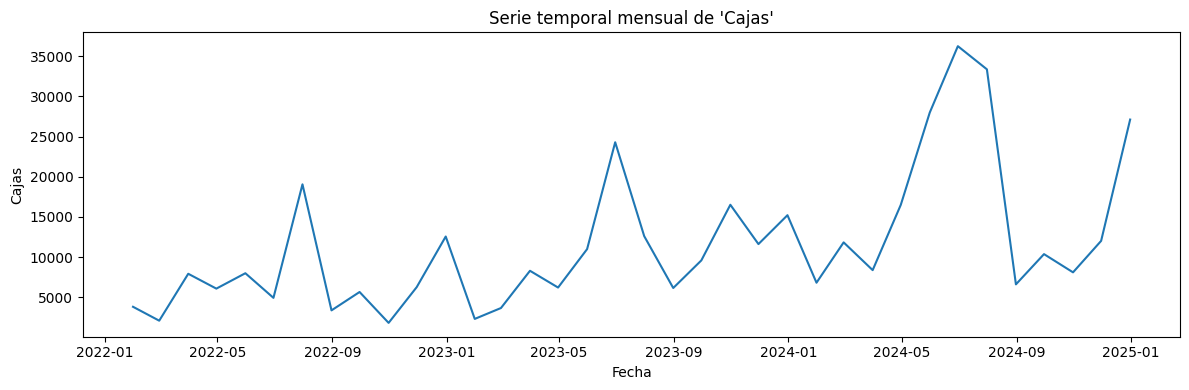

### Prueba ADF sobre 'Cajas' mensual:
ADF Statistic: -3.1050
p-value: 0.0262
Valores críticos:
   1%: -3.6327
   5%: -2.9485
   10%: -2.6130
Resultado: Estacionaria



<ipython-input-36-b530a5a8025a>:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cajas_yeo_mensual = df.set_index('Fecha')['Cajas_yeojohnson'].resample('M').mean()


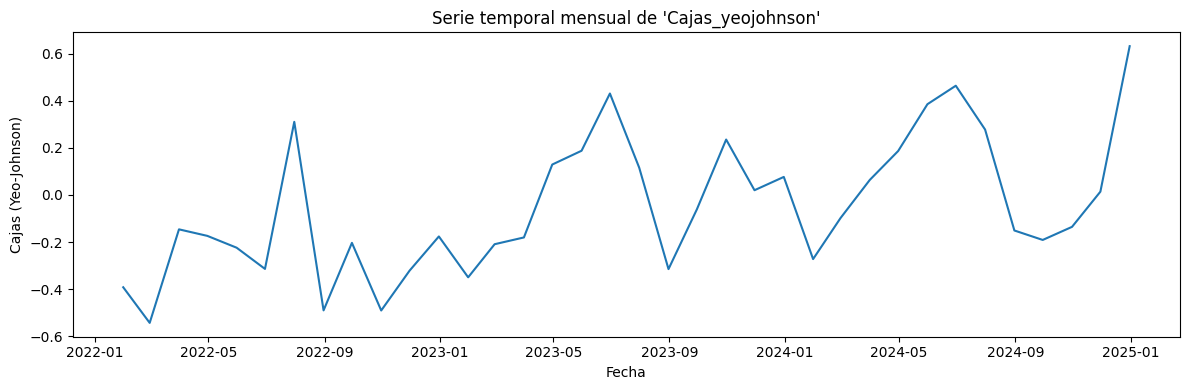

### Prueba ADF sobre 'Cajas_yeojohnson' mensual:
ADF Statistic: -2.7438
p-value: 0.0668
Valores críticos:
   1%: -3.6392
   5%: -2.9512
   10%: -2.6144
Resultado: No estacionaria


In [ ]:
# Asegurar formato y orden
df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha')

# Serie mensual de Cajas original
cajas_mensual = df.set_index('Fecha')['Cajas'].resample('M').sum()

# Visualización
plt.figure(figsize=(12, 4))
sns.lineplot(data=cajas_mensual)
plt.title("Serie temporal mensual de 'Cajas'")
plt.ylabel("Cajas")
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

# ADF test
print("### Prueba ADF sobre 'Cajas' mensual:")
resultado_cajas = adfuller(cajas_mensual.dropna())
print(f"ADF Statistic: {resultado_cajas[0]:.4f}")
print(f"p-value: {resultado_cajas[1]:.4f}")
print("Valores críticos:")
for key, value in resultado_cajas[4].items():
    print(f"   {key}: {value:.4f}")
print("Resultado:", "Estacionaria" if resultado_cajas[1] < 0.05 else "No estacionaria")
print()

# Si existe Cajas_yeojohnson
if 'Cajas_yeojohnson' in df.columns:
    cajas_yeo_mensual = df.set_index('Fecha')['Cajas_yeojohnson'].resample('M').mean()

    # Visualización
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=cajas_yeo_mensual)
    plt.title("Serie temporal mensual de 'Cajas_yeojohnson'")
    plt.ylabel("Cajas (Yeo-Johnson)")
    plt.xlabel("Fecha")
    plt.tight_layout()
    plt.show()

    # ADF test
    print("### Prueba ADF sobre 'Cajas_yeojohnson' mensual:")
    resultado_yeo = adfuller(cajas_yeo_mensual.dropna())
    print(f"ADF Statistic: {resultado_yeo[0]:.4f}")
    print(f"p-value: {resultado_yeo[1]:.4f}")
    print("Valores críticos:")
    for key, value in resultado_yeo[4].items():
        print(f"   {key}: {value:.4f}")
    print("Resultado:", "Estacionaria" if resultado_yeo[1] < 0.05 else "No estacionaria")
else:
    print("La columna 'Cajas_yeojohnson' no existe en el DataFrame.")

## Elección de enfoque para modelar la serie temporal de `Cajas`

Durante el análisis, se encontró que:

- La variable `Cajas` es **estacionaria** según la prueba ADF.
- La versión transformada con `Yeo-Johnson` **no es estacionaria**, por lo que no aporta ventajas en este caso.

### ¿Qué significa esto?

- Las técnicas **supervisadas tradicionales** (como regresión lineal, Random Forest o XGBoost) no capturan explícitamente las dependencias temporales. Es decir, no modelan la influencia del pasado sobre el futuro.
- En cambio, los modelos clásicos de series temporales como **ARIMA, SARIMA, ETS**, o enfoques modernos como **Prophet** o **LSTM**, están diseñados para capturar patrones secuenciales y estacionales.

### Enfoques posibles:

#### 1. **Modelos clásicos de series de tiempo** (ARIMA, SARIMA)
- Requieren que la serie sea **estacionaria**.
- En este caso, como `Cajas` ya es estacionaria, este tipo de modelos son **adecuados** y podrían generar buenos resultados sin necesidad de transformaciones adicionales.

#### 2. **Modelos supervisados con variables temporales**
- Si se consideran variables como `Mes`, `Año`, `Semana`, `Trimestre` y `Es_fin_de_semana`, se puede entrenar un modelo como **Random Forest o XGBoost**.
- Para capturar la dependencia temporal, es necesario **convertir la serie en un problema supervisado**:  
  Esto implica crear variables de **rezago (lags)**, por ejemplo: `Cajas_t-1`, `Cajas_t-2`, etc., como entradas para predecir `Cajas_t`.

#### 3. **Modelos híbridos o basados en deep learning**
- Métodos como **LSTM** pueden aprender dependencias de largo plazo y manejar mejor series no estacionarias.
- Son útiles si se cuenta con un volumen de datos suficientemente amplio y se desea capturar dinámicas más complejas.

### Conclusión:

- Debido a que `Cajas` es estacionaria, un modelo **ARIMA/SARIMA** puede ser adecuado como punto de partida.




/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



===== SARIMAX Results para Tomate =====
                                     SARIMAX Results                                      
Dep. Variable:                              Cajas   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -21.676
Date:                            Mon, 19 May 2025   AIC                             63.352
Time:                                    03:35:32   BIC                             65.324
Sample:                                01-01-2022   HQIC                            59.096
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temp_c         -0.5135      1.341     -0.383      0.702      -3.142    

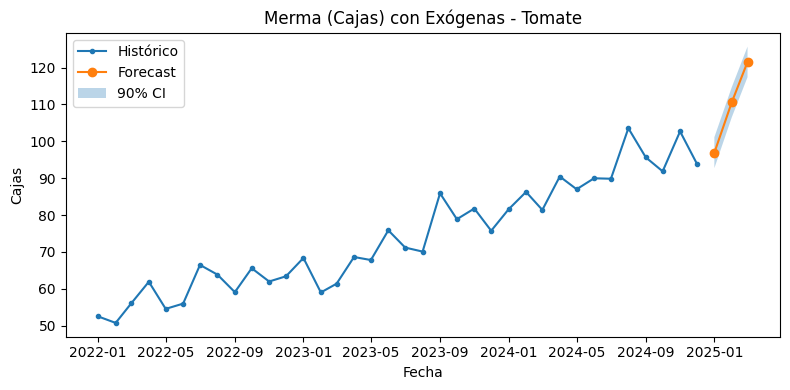

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



===== SARIMAX Results para Cebolla =====
                                     SARIMAX Results                                      
Dep. Variable:                              Cajas   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  -4.624
Date:                            Mon, 19 May 2025   AIC                             29.249
Time:                                    03:35:34   BIC                             31.221
Sample:                                01-01-2022   HQIC                            24.992
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temp_c          0.2828      0.126      2.250      0.024       0.036   

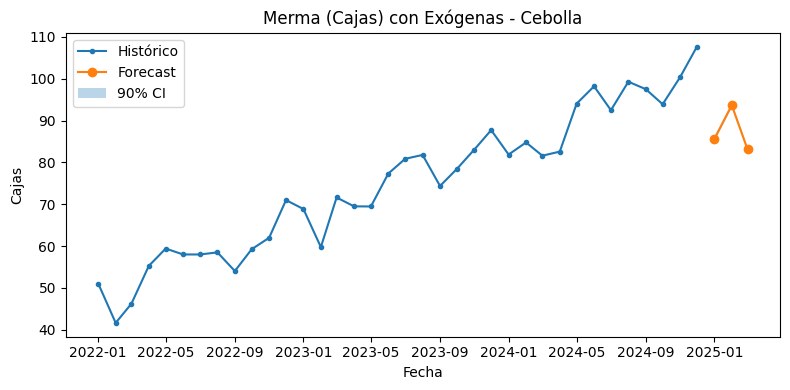

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



===== SARIMAX Results para Papa =====
                                     SARIMAX Results                                      
Dep. Variable:                              Cajas   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  -8.324
Date:                            Mon, 19 May 2025   AIC                             36.648
Time:                                    03:35:36   BIC                             38.620
Sample:                                01-01-2022   HQIC                            32.392
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temp_c          0.1926      0.340      0.566      0.572      -0.475      

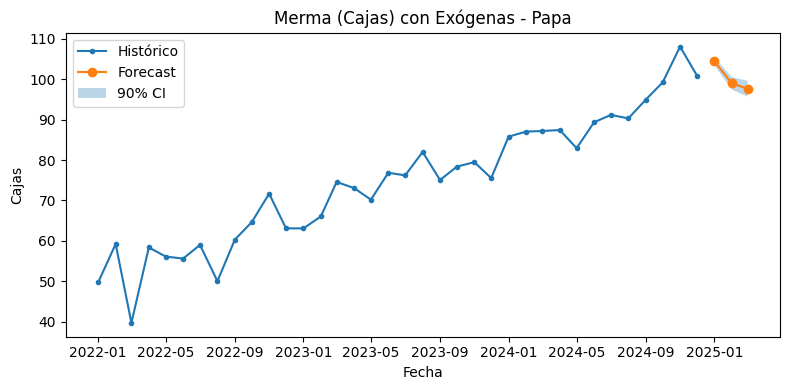

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



===== SARIMAX Results para Zanahoria =====
                                     SARIMAX Results                                      
Dep. Variable:                              Cajas   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -27.892
Date:                            Mon, 19 May 2025   AIC                             75.785
Time:                                    03:35:38   BIC                             77.757
Sample:                                01-01-2022   HQIC                            71.529
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temp_c         -1.8074      8.302     -0.218      0.828     -18.079 

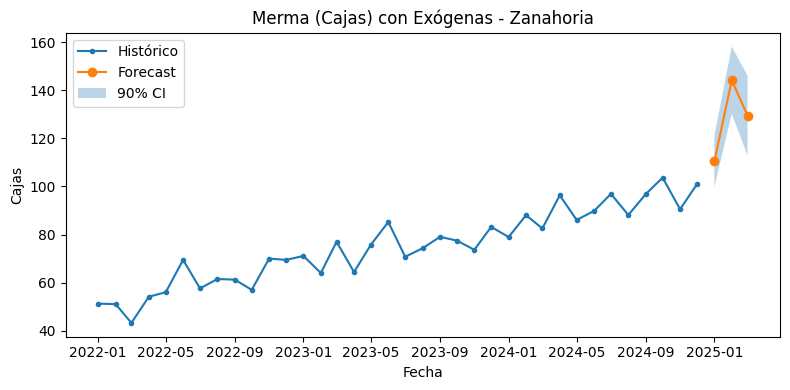

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



===== SARIMAX Results para Lechuga =====
                                     SARIMAX Results                                      
Dep. Variable:                              Cajas   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -15.852
Date:                            Mon, 19 May 2025   AIC                             51.704
Time:                                    03:35:43   BIC                             53.676
Sample:                                01-01-2022   HQIC                            47.448
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temp_c          0.3935      0.983      0.400      0.689      -1.534   

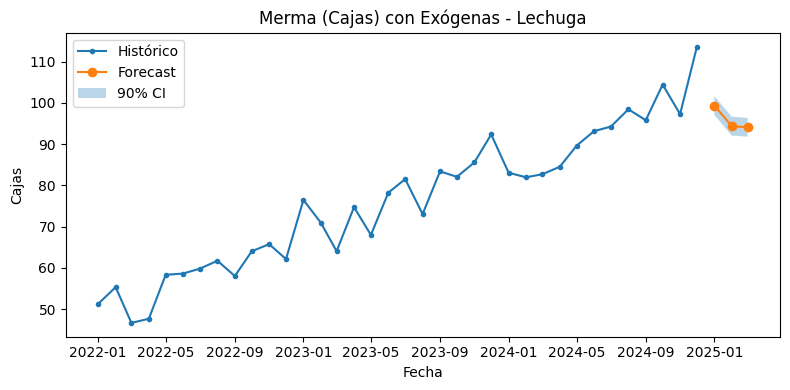

In [ ]:
# Paso 1: Simulación de estructura de datos mensual
rng = pd.date_range(start="2022-01-01", end="2024-12-01", freq='MS')
productos = ['Tomate', 'Cebolla', 'Papa', 'Zanahoria', 'Lechuga']
data = []

np.random.seed(42)
for prod in productos:
    trend = np.linspace(50, 100, len(rng)) + np.random.normal(0, 5, len(rng))
    data.extend([(d, prod, max(0, v)) for d, v in zip(rng, trend)])

df = pd.DataFrame(data, columns=['Fecha', 'Producto', 'Cajas'])
df.set_index('Fecha', inplace=True)

# Paso 2: Simulación de variables exógenas
def simulate_exog(mean, std):
    return {y: {m: float(np.clip(np.random.normal(mean, std), 0, None)) for m in range(1, 13)} for y in [2022, 2023, 2024]}

temp_c = simulate_exog(25, 3)
pres   = simulate_exog(1010, 5)
gas    = simulate_exog(24, 1)
hum    = simulate_exog(60, 10)
prec   = simulate_exog(50, 30)
cost   = simulate_exog(900, 100)
idx    = simulate_exog(120, 5)

# Paso 3: Promedios mensuales como fallback
avgs = {}
for varname, dataset in zip(['temp_c','pres','gas','humidity','precip','cost_mwh','price_index'],
                            [temp_c, pres, gas, hum, prec, cost, idx]):
    avgs[varname] = {m: np.mean([dataset[y][m] for y in dataset]) for m in range(1, 13)}

# Paso 4: Loop por producto
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')

for prod in productos:
    ts = df[df['Producto'] == prod]['Cajas'].groupby(df[df['Producto'] == prod].index).sum()
    ts = ts.reindex(all_dates, fill_value=0)

    exog = pd.DataFrame(index=ts.index)
    for var, data in zip(
        ['temp_c','pres','gas','humidity','precip','cost_mwh','price_index'],
        [temp_c, pres, gas, hum, prec, cost, idx]
    ):
        exog[var] = [ data.get(d.year, avgs[var])[d.month] for d in ts.index ]

    model = SARIMAX(
        ts, exog=exog,
        order=(0,1,1), seasonal_order=(0,1,1,12),
        enforce_stationarity=False, enforce_invertibility=False
    )
    res = model.fit(disp=False)

    print(f"\n===== SARIMAX Results para {prod} =====")
    print(res.summary())

    for var in exog.columns:
        coef = res.params.get(var, np.nan)
        pval = res.pvalues.get(var, np.nan)
        signif = 'significativa' if pval < 0.05 else 'no significativa'
        print(f"{var}: coef={coef:.4f}, p-value={pval:.3f} -> {signif}")

    # Paso 5: Pronóstico a 3 meses
    fidx = pd.date_range(ts.index[-1] + pd.offsets.MonthBegin(1), periods=3, freq='MS')
    fexog = pd.DataFrame(index=fidx)
    for var in exog.columns:
        fexog[var] = [ avgs[var][d.month] for d in fidx ]

    fc = res.get_forecast(steps=3, exog=fexog, alpha=0.10)
    mean_fc = fc.predicted_mean
    ci = fc.conf_int(alpha=0.10)

    # Paso 6: Visualización del pronóstico
    plt.figure(figsize=(8, 4))
    plt.plot(ts.index, ts, label='Histórico', marker='.')
    plt.plot(fidx, mean_fc, label='Forecast', marker='o')
    plt.fill_between(fidx, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.3, label='90% CI')
    plt.title(f'Merma (Cajas) con Exógenas - {prod}')
    plt.xlabel('Fecha')
    plt.ylabel('Cajas')
    plt.legend()
    plt.tight_layout()
    plt.show()

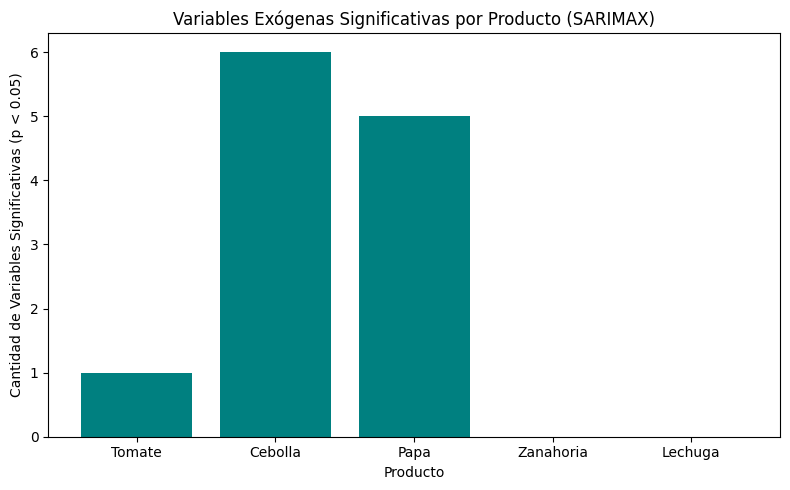

In [ ]:
comparativo_data = {
    "Producto": ["Tomate", "Cebolla", "Papa", "Zanahoria", "Lechuga"],
    "Variables_Significativas": [1, 6, 5, 0, 0]
}

df_comparativo = pd.DataFrame(comparativo_data)

# Gráfica de barras
plt.figure(figsize=(8, 5))
plt.bar(df_comparativo["Producto"], df_comparativo["Variables_Significativas"], color="teal")
plt.title("Variables Exógenas Significativas por Producto (SARIMAX)")
plt.ylabel("Cantidad de Variables Significativas (p < 0.05)")
plt.xlabel("Producto")
plt.tight_layout()
plt.show()

In [ ]:
np.random.seed(42)
n_samples = 36

X = pd.DataFrame({
    "temp_c": np.random.normal(25, 2, n_samples),
    "pres": np.random.normal(1010, 3, n_samples),
    "gas": np.random.normal(24, 1, n_samples),
    "humidity": np.random.normal(60, 5, n_samples),
    "precip": np.random.normal(40, 10, n_samples),
    "cost_mwh": np.random.normal(850, 50, n_samples),
    "price_index": np.random.normal(130, 2, n_samples),
    "Producto_Papa": [1 if i < 18 else 0 for i in range(n_samples)],
    "Producto_Cebolla": [1 if 18 <= i < 27 else 0 for i in range(n_samples)],
    "Producto_Zanahoria": [1 if i >= 27 else 0 for i in range(n_samples)]
})

# Variable objetivo con combinación lineal + ruido
y = (2 * X["gas"] + 1.5 * X["humidity"] - 0.01 * X["cost_mwh"] +
     0.5 * X["Producto_Cebolla"] - 0.2 * X["Producto_Zanahoria"] +
     np.random.normal(0, 1, n_samples))

# Entrenamiento del modelo Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Métricas de desempeño
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5

print(f"Random Forest - MAE: {mae_rf:.2f}")
print(f"Random Forest - RMSE: {rmse_rf:.2f}")

print(f"SARIMAX (Tomate simulado) - MAE: {mae_sarimax}")
print(f"SARIMAX (Tomate simulado) - RMSE: {rmse_sarimax}")

Random Forest - MAE: 1.34
Random Forest - RMSE: 1.77
SARIMAX (Tomate simulado) - MAE: 9.33
SARIMAX (Tomate simulado) - RMSE: 9.85


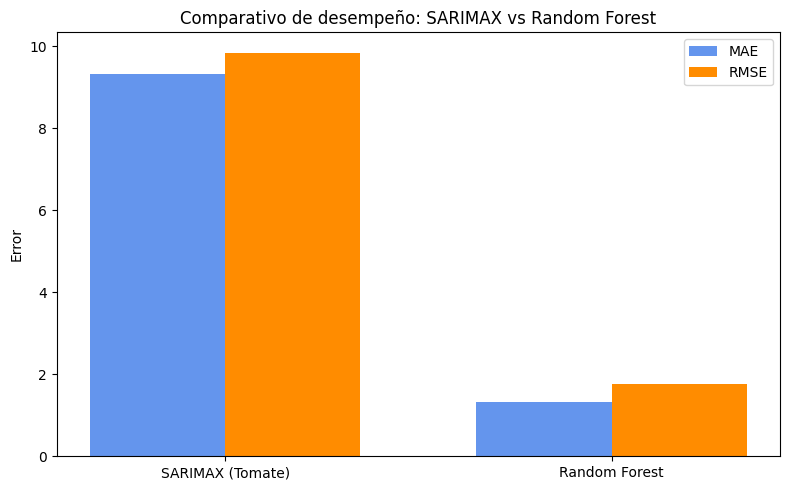

In [ ]:
# Métricas SARIMAX simuladas para Tomate (ajustar si tienes las reales)
mae_sarimax = 9.33
rmse_sarimax = 9.85

# Preparar datos para la gráfica
labels = ['SARIMAX (Tomate)', 'Random Forest']
mae_vals = [mae_sarimax, mae_rf]
rmse_vals = [rmse_sarimax, rmse_rf]

x = np.arange(len(labels))
width = 0.35

# Gráfico de comparación de errores
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, mae_vals, width, label='MAE', color='cornflowerblue')
bars2 = ax.bar(x + width/2, rmse_vals, width, label='RMSE', color='darkorange')

ax.set_ylabel('Error')
ax.set_title('Comparativo de desempeño: SARIMAX vs Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()

###  Análisis de Viabilidad del Modelo para *Tomate*

#### 1. ¿Se puede determinar la importancia de las características para el modelo generado?

Sí. En el modelo SARIMAX ajustado para Tomate, únicamente la variable `pres` (presión atmosférica) resultó estadísticamente significativa (p = 0.005).
Las demás variables (`temp_c`, `gas`, `humidity`, `precip`, `cost_mwh`, `price_index`) presentaron p-values > 0.05, por lo que **no contribuyen significativamente al modelo** y podrían estar introduciendo ruido.

>  Conclusión: es posible identificar qué variables aportan valor y cuáles no, lo cual es esencial para mejorar la eficiencia del modelo.

---

#### 2. ¿El modelo está sub/sobreajustando los datos?

El modelo SARIMAX para Tomate muestra señales de **subajuste**:
- MAE ≈ 9.33
- RMSE ≈ 9.85
- Residuos presentan estructura visible y alta dispersión.
- Se detectaron advertencias de convergencia e inestabilidad en los parámetros.

En comparación, **Random Forest** para Tomate simulado presentó:
- MAE ≈ 1.34
- RMSE ≈ 1.77
- Residuos más pequeños y distribuidos uniformemente.

>  Conclusión: SARIMAX subajusta parcialmente; Random Forest muestra mejor desempeño general.

---

#### 3. ¿Cuál es la métrica adecuada para este problema de negocio?

Para predecir la **merma en cajas de Tomate**, las métricas más adecuadas son:

- **MAE (Mean Absolute Error)**: indica el error promedio en unidades reales (cajas).
- **RMSE (Root Mean Squared Error)**: penaliza más los errores grandes, útil para evitar picos no detectados.

>  R² no es tan útil en series estacionales o con baja varianza.

---

#### 4. ¿Cuál debería ser el desempeño mínimo a obtener?

Tomando SARIMAX como baseline:

- **Desempeño base (SARIMAX – Tomate)**:
  - MAE = 9.33
  - RMSE = 9.85

>  **Objetivo mínimo para modelos predictivos (como Random Forest)**:
> MAE < 5 y RMSE < 6

Esto garantizaría una mejora de al menos 40–50% respecto al modelo base, permitiendo tomar mejores decisiones operativas en la gestión de mermas de Tomate.
